In [75]:
from openmmtools.states import SamplerState, ThermodynamicState, CompoundThermodynamicState
from simtk import unit, openmm
from perses.tests.utils import compute_potential_components
from openmmtools.constants import kB
from perses.dispersed.utils import configure_platform
from perses.annihilation.rest import RESTTopologyFactory
from perses.annihilation.lambda_protocol import RESTState
import numpy as np
from perses.tests.test_topology_proposal import generate_atp, generate_dipeptide_top_pos_sys
from openmmtools.testsystems import AlanineDipeptideVacuum, AlanineDipeptideExplicit
import itertools
from perses.tests.test_topology_proposal import generate_dipeptide_top_pos_sys, generate_atp
import pickle
import copy

#############################################
# CONSTANTS
#############################################
temperature = 298.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
REFERENCE_PLATFORM = openmm.Platform.getPlatformByName("Reference")


In [152]:
def test_nb_energies(htf, is_old=True, is_solvated=False, check_scale=False):
    htf_copy = copy.deepcopy(htf)

    # Get system and old/new positions
    system = htf._topology_proposal.old_system if is_old else htf._topology_proposal.new_system
    positions = htf.old_positions(htf.hybrid_positions) if is_old else htf.new_positions(htf.hybrid_positions)

    # Get nb force
    nb_force_index = 3 
    nb_force = system.getForce(nb_force_index) 

    # Get system and positions
    hybrid_system = htf.hybrid_system
    hybrid_positions = htf.hybrid_positions

    # Get custom nb force 
    custom_nb_force_index = 3 if not is_solvated else 4
    custom_nb_exceptions_force_index = 4 if not is_solvated else 5
    standard_nb_force_index = 5 if not is_solvated else 6
   
    custom_nb_force = hybrid_system.getForce(custom_nb_force_index)
    custom_nb_exceptions_force = hybrid_system.getForce(custom_nb_exceptions_force_index)
    standard_nb_force = hybrid_system.getForce(standard_nb_force_index)

    for i in range(nb_force.getNumParticles()):
        charge, sigma, epsilon = nb_force.getParticleParameters(i)
        if i in htf._atom_classes['environment_atoms']:
            nb_force.setParticleParameters(i, charge*0, sigma, epsilon*0)
#         else:
#             nb_force.setParticleParameters(i, charge*0, sigma, epsilon)
    
    for i in range(nb_force.getNumExceptions()):
        p1, p2, chargeProd, sigma, epsilon = nb_force.getExceptionParameters(i)
        if p1 in htf._atom_classes['environment_atoms']:
            nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
#         else:
#             nb_force.setExceptionParameters(i, p1, p2, chargeProd*0, sigma, epsilon*0)
    
    for i in range(custom_nb_force.getNumParticles()):
        params = custom_nb_force.getParticleParameters(i)
#         if i in list(htf._atom_classes['environment_atoms'])  +  list(htf._alchemical_regions_by_type['core_atoms']):
        params = list(params)
        if i in htf._atom_classes['environment_atoms']:
            params[7] = params[7]*0
            params[9] = params[9]*0
            params[10] = params[10]*0
            params[12] = params[12]*0
            custom_nb_force.setParticleParameters(i, params)
#         else:
#             params[7] = params[7]*0
#             params[10] = params[10]*0
#             custom_nb_force.setParticleParameters(i, params)
            
    for i in range(custom_nb_exceptions_force.getNumBonds()):
        p1, p2, params = custom_nb_exceptions_force.getBondParameters(i)
#         print(p1, p2, params)
#         if p1 in htf._atom_classes['environment_atoms'] or p2 in htf._atom_classes['environment_atoms'] or p1 in htf._atom_classes['core_atoms'] or p2 in htf._atom_classes['core_atoms']:
        params = list(params)
        if p1 in htf._atom_classes['environment_atoms'] or p2 in htf._atom_classes['environment_atoms']:
            params[7] = params[7]*0
            params[9] = params[9]*0
            params[10] = params[10]*0
            params[12] = params[12]*0
            custom_nb_exceptions_force.setBondParameters(i, p1, p2, params)
#         else:
#             params[7] = params[7]*0
#             params[9] = params[9]*0
#             params[10] = params[10]*0
#             params[12] = params[12]*0
#             custom_nb_exceptions_force.setBondParameters(i, p1, p2, params)
        
    # Set global parameters
    lambda_old = 1 if is_old else 0
    lambda_new = 0 if is_old else 1
    lambda_old_str = ['lambda_alchemical_electrostatics_old', 'lambda_alchemical_sterics_old']
    lambda_new_str = ['lambda_alchemical_electrostatics_new', 'lambda_alchemical_sterics_new']
    lambda_old_exceptions_str = ['lambda_alchemical_electrostatics_exceptions_old', 'lambda_alchemical_sterics_exceptions_old']
    lambda_new_exceptions_str = ['lambda_alchemical_electrostatics_exceptions_new', 'lambda_alchemical_sterics_exceptions_new']
    
    for i in range(custom_nb_force.getNumGlobalParameters()):
        if custom_nb_force.getGlobalParameterName(i) in lambda_old_str:
            custom_nb_force.setGlobalParameterDefaultValue(i, lambda_old)
        elif custom_nb_force.getGlobalParameterName(i) in lambda_new_str:
            custom_nb_force.setGlobalParameterDefaultValue(i, lambda_new)

    for i in range(custom_nb_exceptions_force.getNumGlobalParameters()):
        if custom_nb_exceptions_force.getGlobalParameterName(i) in lambda_old_exceptions_str:
            custom_nb_exceptions_force.setGlobalParameterDefaultValue(i, lambda_old)
        elif custom_nb_exceptions_force.getGlobalParameterName(i) in lambda_new_exceptions_str:
            custom_nb_exceptions_force.setGlobalParameterDefaultValue(i, lambda_new)
                                 
    for i in range(standard_nb_force.getNumGlobalParameters()):
        if standard_nb_force.getGlobalParameterName(i) in ['lambda_alchemical_electrostatics', 'lambda_alchemical_sterics']:
            standard_nb_force.setGlobalParameterDefaultValue(i, lambda_new)

    # Get energy components of standard nb force
    thermostate_other = ThermodynamicState(system=system, temperature=temperature)
    integrator_other = openmm.VerletIntegrator(1.0*unit.femtosecond)
    context_other = thermostate_other.create_context(integrator_other)
    context_other.setPositions(positions)
    components_other = compute_potential_components(context_other, beta=beta, platform=REFERENCE_PLATFORM)
    print(components_other)
    
#     print("running md")
#     energies_other = []
#     for step in range(300):
#         print(f"step {step}")
#         integrator_other.step(1)
#         components_other = compute_potential_components(context_other, beta=beta, platform=REFERENCE_PLATFORM)
#         energies_other.append(components_other[nb_force_index][1])
    
    # Get energy components of custom nb force
    thermostate_hybrid = ThermodynamicState(system=hybrid_system, temperature=temperature)
    integrator_hybrid = openmm.VerletIntegrator(1.0 * unit.femtosecond)
    context_hybrid = thermostate_hybrid.create_context(integrator_hybrid)
    context_hybrid.setPositions(hybrid_positions)
    components_hybrid = compute_potential_components(context_hybrid, beta=beta, platform=REFERENCE_PLATFORM)
    print(components_hybrid)
    
#     print("running md")
#     energies_hybrid = []
#     for step in range(300):
#         print(f"step {step}")
#         integrator_hybrid.step(1)
#         components_hybrid = compute_potential_components(context_hybrid, beta=beta, platform=REFERENCE_PLATFORM)
#         energies_hybrid.append(components_hybrid[3][1])
    

#     assert np.isclose([components_other[nb_force_index][1]], np.sum([energy[1] for i, energy in enumerate(components_hybrid) if i in [custom_nb_force_index, custom_nb_exceptions_force_index, standard_nb_force_index] ])), f"standard nonbonded: {components_other[nb_force_index][1]}, custom nonbonded/bond: {np.sum([energy[1] for i, energy in enumerate(components_hybrid) if i in [custom_nb_force_index, custom_nb_exceptions_force_index, standard_nb_force_index] ])}"

#     print(f"Success! Custom nb force and standard nb force energies are equal!")

#     if check_scale:
        
#         # Get custom nb and custom bond forces and hybrid positions
#         hybrid_system = htf_copy.hybrid_system
#         hybrid_positions = htf_copy.hybrid_positions
        
#         # Get custom nb force 
#         custom_nb_force_index = 3 if not is_solvated else 4
#         custom_nb_exceptions_force_index = 4 if not is_solvated else 5
        
#         custom_nb_force = hybrid_system.getForce(custom_nb_force_index)
#         custom_nb_exceptions_force = hybrid_system.getForce(custom_nb_exceptions_force_index)

#         # Get energy components of custom nb force
#         thermostate_hybrid = ThermodynamicState(system=hybrid_system, temperature=temperature)
#         integrator_hybrid = openmm.VerletIntegrator(1.0 * unit.femtosecond)
#         context_hybrid = thermostate_hybrid.create_context(integrator_hybrid)
#         context_hybrid.setPositions(hybrid_positions)
#         components_hybrid = compute_potential_components(context_hybrid, beta=beta)
#         print(components_hybrid)
        
#         # Set rest lambda to 0.5
#         for i in range(custom_nb_force.getNumGlobalParameters()):
#             if custom_nb_force.getGlobalParameterName(i) == 'lambda_rest_electrostatics':
#                 custom_nb_force.setGlobalParameterDefaultValue(i, 0.5)
#             elif custom_nb_force.getGlobalParameterName(i) == 'lambda_rest_sterics':
#                 custom_nb_force.setGlobalParameterDefaultValue(i, 0.5)
                
#         for i in range(custom_nb_exceptions_force.getNumGlobalParameters()):
#             if custom_nb_exceptions_force.getGlobalParameterName(i) == 'lambda_rest_electrostatics_exceptions':
#                 custom_nb_exceptions_force.setGlobalParameterDefaultValue(i, 0.5)
#             elif custom_nb_exceptions_force.getGlobalParameterName(i) == 'lambda_rest_sterics_exceptions':
#                 custom_nb_exceptions_force.setGlobalParameterDefaultValue(i, 0.5)
            
#         ## Get energy components of custom torsion force iwth scaling
#         thermostate_hybrid = ThermodynamicState(system=hybrid_system, temperature=temperature)
#         integrator_hybrid = openmm.VerletIntegrator(1.0 * unit.femtosecond)
#         context_hybrid = thermostate_hybrid.create_context(integrator_hybrid)
#         context_hybrid.setPositions(hybrid_positions)
#         components_hybrid_scaled = compute_potential_components(context_hybrid, beta=beta)
#         print(components_hybrid_scaled)
        
#         assert not np.isclose([components_hybrid[custom_nb_force_index][1]], [components_hybrid_scaled[custom_nb_force_index][1]])
#         assert not np.isclose([components_hybrid[custom_nb_exceptions_force_index][1]], [components_hybrid_scaled[custom_nb_exceptions_force_index][1]])
        
#         print(f"Success! Scaling the custom nb and bond forces changes the energy")
        
#     return energies_other, energies_hybrid

# Alanine dipeptide in vacuum

### Test one alchemical region, no scale regions

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [48]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/31_rest_over_protocol/atp_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)

In [49]:
htf._r_cutoff

Quantity(value=100, unit=nanometer)

In [50]:
test_nb_energies(htf)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 0.0347836535652138), ('HarmonicAngleForce', 0.6112775462128993), ('PeriodicTorsionForce', 16.285398289983057), ('NonbondedForce', -39.449927745600284), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 0.0347836535652138), ('CustomAngleForce', 0.6112775462128993), ('CustomTorsionForce', 16.285403285921717), ('CustomNonbondedForce', -130.55774492044804), ('CustomBondForce', 91.10781400532242), ('NonbondedForce', 0.0), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force energies are equal!


<openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2baa02212cc0> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [51]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/31_rest_over_protocol/atp_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)

In [52]:
test_nb_energies(htf, is_old=False)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 1.7533924299367394), ('HarmonicAngleForce', 265.6677928204255), ('PeriodicTorsionForce', 25.881782322451524), ('NonbondedForce', 407.2892526962738), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 0.0347836535652138), ('CustomAngleForce', 0.6112775462128993), ('CustomTorsionForce', 16.285403285921717), ('CustomNonbondedForce', -79.49811878075636), ('CustomBondForce', 486.7873687513989), ('NonbondedForce', 0.0), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force energies are equal!


<openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2ba9cbc45810> >

### Test one alchemical region, one scale region

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [31]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/31_rest_over_protocol/atp_vacuum_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [32]:
test_nb_energies(htf, check_scale=True)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 0.0347836535652138), ('HarmonicAngleForce', 0.6112775462128993), ('PeriodicTorsionForce', 16.285398289983057), ('NonbondedForce', -39.449927745600284), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 0.0347836535652138), ('CustomAngleForce', 0.6112775462128993), ('CustomTorsionForce', 16.285403285921717), ('CustomNonbondedForce', -130.5577432119903), ('CustomBondForce', 91.1078186820756), ('NonbondedForce', 0.0), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 0.0347836535652138), ('CustomAngleForce', 0.6112775462128993), ('CustomTorsionForce', 16.285403285921717), ('CustomNonbondedForce', -130.5577432119903), ('CustomBondForce', 91.1078186820756), ('Nonb

<openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2ba9f0001480> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [33]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/31_rest_over_protocol/atp_vacuum_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [34]:
test_nb_energies(htf, is_old=False, check_scale=True)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 0.34717794777053645), ('HarmonicAngleForce', 2.6613512766961778), ('PeriodicTorsionForce', 26.628276332415044), ('NonbondedForce', 493.81950799233925), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 0.0347836535652138), ('CustomAngleForce', 0.6112775462128993), ('CustomTorsionForce', 16.285403285921717), ('CustomNonbondedForce', 480.253488017234), ('CustomBondForce', 13.566319605554744), ('NonbondedForce', 0.0), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 0.0347836535652138), ('CustomAngleForce', 0.6112775462128993), ('CustomTorsionForce', 16.285403285921717), ('CustomNonbondedForce', -130.5577432119903), ('CustomBondForce', 91.1078186820756), ('Nonb

<openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2ba9f7eaa600> >

# Alanine dipeptide in solvent

### Test one alchemical region, no scale regions

#### Old system nb force vs hybrid system custom nb force and custom bond force (electrostatics)

In [153]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/31_rest_over_protocol/atp_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [121]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ae3b506abd0> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ae3b506ab70> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ae3b506aba0> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ae3b506ae40> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2ae3b506ac90> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ae3b506af00> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2ae3b506af90> >]

In [154]:
htf._topology_proposal.old_system.getForce(3).setReciprocalSpaceForceGroup(31)

In [148]:
# htf._topology_proposal.old_system.getForce(3).setUseDispersionCorrection(False)

In [155]:
htf.hybrid_system.getForce(4).setUseLongRangeCorrection(True)

In [150]:
# htf._topology_proposal.old_system.getForce(3).setIncludeDirectSpace(False)

In [156]:
energies_other, energies_hybrid = test_nb_energies(htf, is_solvated=True)

conducting subsequent work with the following platform: Reference
[('HarmonicBondForce', 0.03478347046543876), ('HarmonicAngleForce', 0.6112776764392966), ('PeriodicTorsionForce', 16.28539847276254), ('NonbondedForce', 153.3520669226475), ('AndersenThermostat', 0.0), ('MonteCarloBarostat', 0.0)]
conducting subsequent work with the following platform: Reference
[('CustomBondForce', 0.03478347046543876), ('CustomAngleForce', 0.6112776764392966), ('CustomTorsionForce', 16.28539847276254), ('CustomNonbondedForce', -21.763196679965723), ('CustomBondForce', 25.88461738358351), ('NonbondedForce', -49300.72430979579), ('AndersenThermostat', 0.0), ('MonteCarloBarostat', 0.0)]


TypeError: cannot unpack non-iterable NoneType object

In [115]:
import matplotlib.pyplot as plt

DEBUG:matplotlib:matplotlib data path: /home/zhangi/miniconda3/envs/perses-rest-over-protocol/lib/python3.8/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/zhangi/.config/matplotlib
DEBUG:matplotlib:matplotlib version 3.4.3
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'posix', '_frozen_importlib_external', '_thread', '_weakref', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections'

DEBUG:matplotlib:CACHEDIR=/home/zhangi/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/zhangi/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


(array([65., 75., 61., 48., 26.,  7.,  4.,  3.,  4.,  7.]),
 array([-1.95081102, -1.74725317, -1.54369531, -1.34013746, -1.1365796 ,
        -0.93302175, -0.72946389, -0.52590604, -0.32234818, -0.11879033,
         0.08476752]),
 <BarContainer object of 10 artists>)

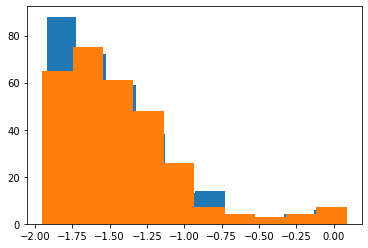

In [134]:
plt.hist(energies_other)
plt.hist(energies_hybrid)

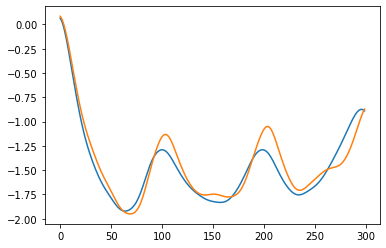

In [135]:
plt.plot(np.array(energies_other))
plt.plot(np.array(energies_hybrid))

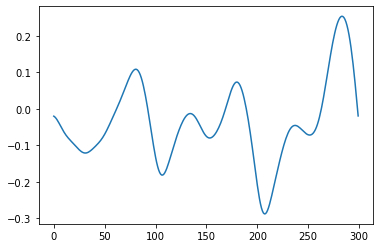

In [136]:
plt.plot(np.array(energies_other) - np.array(energies_hybrid))

In [137]:
np.std(np.array(energies_other) - np.array(energies_hybrid))

0.1103941451005837

In [117]:
for i in range(htf.hybrid_system.getForce(4).getNumParticles()):
    print(i, htf.hybrid_system.getForce(4).getParticleParameters(i))

0 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2649532787749369, 0.06568879999999999, 0.0, 0.2649532787749369, 0.06568879999999999)
1 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.3399669508423535, 0.4577296, -0.0, 0.3399669508423535, 0.4577296)
2 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2649532787749369, 0.06568879999999999, 0.0, 0.2649532787749369, 0.06568879999999999)
3 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.2649532787749369, 0.06568879999999999, 0.0, 0.2649532787749369, 0.06568879999999999)
4 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.3399669508423535, 0.359824, 0.0, 0.3399669508423535, 0.359824)
5 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.2959921901149463, 0.87864, -0.0, 0.2959921901149463, 0.87864)
6 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -0.0, 0.3249998523775958, 0.7112800000000001, -0.0, 0.3249998523775958, 0.7112800000000001)
7 (0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.10690784617684071, 0.06568879999999999, 0.0, 0.10690784617684071, 0.06568879999999999)
8 (0.0, 1.0, 0.0, 0.

In [72]:
htf._atom_classes['environment_atoms']

{22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201

In [63]:
htf.hybrid_system.getForces()

[<openmm.openmm.MonteCarloBarostat; proxy of <Swig Object of type 'OpenMM::MonteCarloBarostat *' at 0x2ba9ccf74270> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2ba9ccf747b0> >,
 <openmm.openmm.CustomAngleForce; proxy of <Swig Object of type 'OpenMM::CustomAngleForce *' at 0x2ba9c4fb4a80> >,
 <openmm.openmm.CustomTorsionForce; proxy of <Swig Object of type 'OpenMM::CustomTorsionForce *' at 0x2ba9ccfed660> >,
 <openmm.openmm.CustomNonbondedForce; proxy of <Swig Object of type 'OpenMM::CustomNonbondedForce *' at 0x2baa6ea9cc30> >,
 <openmm.openmm.CustomBondForce; proxy of <Swig Object of type 'OpenMM::CustomBondForce *' at 0x2baa6ea9ccc0> >,
 <openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x2baa6ea9cd50> >]

In [64]:
htf.hybrid_system.getForce(4).getEnergyFunction()

'U_electrostatics + U_sterics; U_electrostatics = 138.935456 * chargeProd  * erfc(alpha * r)/ r_eff_electrostatics; U_sterics = 4 * epsilon * x * (x - 1.0);x = (sigma / r_eff_sterics)^6;chargeProd = (charge1 * p1_electrostatics_rest_scale) * (charge2 * p2_electrostatics_rest_scale); charge1 = (is_unique_old1 * old_charge_scaled1) + (is_unique_new1 * new_charge_scaled1) + is_core1 * (old_charge_scaled1 + new_charge_scaled1) + is_environment1 * (old_charge_scaled1 + new_charge_scaled1); old_charge_scaled1 = lambda_alchemical_electrostatics_old * charge_old1; new_charge_scaled1 = lambda_alchemical_electrostatics_new * charge_new1; charge2 = (is_unique_old2 * old_charge_scaled2) + (is_unique_new2 * new_charge_scaled2) + is_core2 * (old_charge_scaled2 + new_charge_scaled2) + is_environment2 * (old_charge_scaled2 + new_charge_scaled2); old_charge_scaled2 = lambda_alchemical_electrostatics_old * charge_old2; new_charge_scaled2 = lambda_alchemical_electrostatics_new * charge_new2; sigma = (sig

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [56]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/atp_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [57]:
test_nb_energies(htf, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 1.9354122356346202), ('HarmonicAngleForce', 3.6005321167873987), ('PeriodicTorsionForce', 26.07468251170674), ('NonbondedForce', -7806.242439792879), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 1.935932439561947), ('CustomAngleForce', 4.051651892412213), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -7789.345291713065), ('CustomNonbondedForce', 1271.8269495978834), ('CustomBondForce', -16.897057128136233), ('CustomBondForce', 8.413314804589984), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b9ae7542900> >

### Test one alchemical region, one scale region

In [59]:
# Create a htf
atp, system_generator = generate_atp(phase = 'solvent')
atp.system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
atp.system.getForce(3).setUseDispersionCorrection(False)
for i in range(atp.system.getNumForces()):
    if i == 3:
        atp.system.getForce(i).setExceptionsUsePeriodicBoundaryConditions(False)
    elif i < 3: # do not set PBCs for barostat
        atp.system.getForce(i).setUsesPeriodicBoundaryConditions(False)
atp.system.removeForce(4) # Remove barostat
htf = generate_dipeptide_top_pos_sys(atp.topology, 
                               'THR', 
                               atp.system, 
                               atp.positions, 
                               system_generator,
                                rxn_field=True,
                               flatten_torsions=True,
                               flatten_exceptions=True,
                               validate_endstate_energy=False,
                                conduct_htf_prop=True, 
                                scale_regions=[[10, 11, 12, 13, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564]])


htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
htf._topology_proposal.new_system.removeForce(4) # Remove barostat

DEBUG:openmmforcefields.system_generators:Trying GAFFTemplateGenerator to load gaff-2.11
INFO:proposal_generator:	Conducting polymer point mutation proposal...
INFO:proposal_generator:Using matching_criterion to chose best atom map
INFO:proposal_generator:Scaffold has symmetry of 0
INFO:proposal_generator:len [{9: 7}, {10: 7}, {11: 7}, {12: 7}, {13: 7}, {9: 8}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {9: 9}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
INFO:proposal_generator:{9: 7}
INFO:proposal_generator:{10: 7}
INFO:proposal_generator:{11: 7}


making topology proposal


INFO:proposal_generator:{12: 7}
INFO:proposal_generator:{13: 7}
INFO:proposal_generator:{9: 8}
INFO:proposal_generator:{10: 8}
INFO:proposal_generator:{11: 8}
INFO:proposal_generator:{12: 8}
INFO:proposal_generator:{13: 8}
INFO:proposal_generator:{9: 9}
INFO:proposal_generator:{10: 9}
INFO:proposal_generator:{11: 9}
INFO:proposal_generator:{12: 9}
INFO:proposal_generator:{13: 9}
INFO:proposal_generator:Returning map that best satisfies matching_criterion
INFO:proposal_generator:Finding best map using matching_criterion name
INFO:proposal_generator:{9: 7}
INFO:geometry:propose: performing forward proposal
INFO:geometry:propose: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 8
INFO:geometry:Atom index proposal order is [10, 14, 18, 13, 15, 17, 16, 19]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is forward; crea

generating geometry engine
making geometry proposal from ALA to THR


INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 11 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 43 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 72 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
INFO:geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
INFO:geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
INFO:geometry:		there are 1654 in the reference Nonbonded force
INFO:geometry:Neglected angle terms : []
INFO:geometry:omitted_growth_terms: {'bonds': [], 'angles': [], 'torsions': [], '1,4s': []}
INFO:geometry:extra torsions: {0: (7, 6, 8, 10, [1, Quantity(value=0.99000

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 8 new atoms
INFO:geometry:	reduced angle potential = 0.19711556435713273.
INFO:geometry:	reduced angle potential = 0.5063325081267936.
INFO:geometry:	reduced angle potential = 0.0010634705818818718.
INFO:geometry:	reduced angle potential = 1.5533562600417.
INFO:geometry:	reduced angle potential = 0.012891566226709741.
INFO:geometry:	reduced angle potential = 0.05115620283566464.
INFO:geometry:	reduced angle potential = 0.037791316896063146.
INFO:geometry:	reduced angle potential = 0.8116170349519928.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 11 bond forces in the no-nonbonded final system
INFO:geometr

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: -47.92948920147241
INFO:geometry:final reduced energy -38.81301025997128
INFO:geometry:sum of energies: -38.813008059760364
INFO:geometry:magnitude of difference in the energies: 2.200210914793388e-06
INFO:geometry:Final logp_proposal: 61.14866449814366


added energy components: [('CustomBondForce', 3.2249312816828275), ('CustomAngleForce', 4.471500203887942), ('CustomTorsionForce', 18.788803641799632), ('CustomBondForce', -74.41472432884282)]


INFO:geometry:logp_reverse: performing reverse proposal
INFO:geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
INFO:geometry:Conducting forward proposal...
INFO:geometry:Computing proposal order with NetworkX...
INFO:geometry:number of atoms to be placed: 4
INFO:geometry:Atom index proposal order is [10, 13, 11, 12]
INFO:geometry:omitted_bonds: []
INFO:geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
INFO:geometry:creating growth system...
INFO:geometry:	creating bond force...
INFO:geometry:	there are 9 bonds in reference force.
INFO:geometry:	creating angle force...
INFO:geometry:	there are 36 angles in reference force.
INFO:geometry:	creating torsion force...
INFO:geometry:	creating extra torsions force...
INFO:geometry:	there are 42 torsions in reference force.
INFO:geometry:	creating nonbonded force...
INFO:geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...

conducting subsequent work with the following platform: CUDA


INFO:geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


INFO:geometry:There are 4 new atoms
INFO:geometry:	reduced angle potential = 0.3517324280898812.
INFO:geometry:	reduced angle potential = 7.39096069988752e-11.
INFO:geometry:	reduced angle potential = 1.2915588460963948e-10.
INFO:geometry:	reduced angle potential = 3.205832446488702e-13.
INFO:geometry:	beginning construction of no_nonbonded final system...
INFO:geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
INFO:geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:geometry:	there are 9 bond forces in the no-nonbonded final system
INFO:geometry:	there are 36 angle forces in the no-nonbonded final system
INFO:geometry:	there are 42 torsion forces in the no-nonbonded final system
INFO:geometry:reverse final system defined with 0 neglected angles.


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced potential before atom placement: 9.11648114171204


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


INFO:geometry:total reduced energy added from growth system: 20.672986672125617
INFO:geometry:final reduced energy 29.78946596595154
INFO:geometry:sum of energies: 29.789467813837657
INFO:geometry:magnitude of difference in the energies: 1.8478861179005435e-06
INFO:geometry:Final logp_proposal: -26852.091213679538


added energy components: [('CustomBondForce', 0.000520203927326505), ('CustomAngleForce', 0.4511197756248138), ('CustomTorsionForce', 7.250463328533253), ('CustomBondForce', 12.970883364040223)]


INFO:relative:*** Generating RxnHybridTopologyFactory ***
INFO:relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
INFO:relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
INFO:relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
INFO:relative:No unknown forces.
INFO:relative:Nonbonded method to be used (i.e. from old system): 0
INFO:relative:Adding and mapping old atoms to hybrid system...
INFO:relative:Adding and mapping new atoms to hybrid system...
INFO:relative:scale_templates: [['nonscale_lambda', 'scale_lambda_0', 'interscale_lambda_0'], ['nonscale_region', 'scale_region_0', 'interscale_region_0']]
INFO:relative:particle (nonbonded) scale_templates: [['nonscale_lambda', 'scale_lambda_0'], ['nonscale_region1', 'scale_region_01'], ['nonscale_region2', 'scale_region_02']]
INFO:re

In [60]:
# Save htf
with open("atp_solvent_scale_region.pickle", "wb") as f:
    pickle.dump(htf, f)

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [61]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [62]:
# This is the scale region
list(htf._atom_classes['unique_old_atoms'][0]) + list(htf._atom_classes['unique_new_atoms'][0])

[10, 11, 12, 13, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564]

In [63]:
test_nb_energies(htf, is_solvated=True, check_scale=True)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 0.03455176254144571), ('HarmonicAngleForce', 0.6072023625714803), ('PeriodicTorsionForce', 16.17682896804984), ('NonbondedForce', -7741.198424138051), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -7823.285446356815), ('CustomNonbondedForce', 1278.0467883801186), ('CustomBondForce', 82.08711377403033), ('CustomBondForce', 8.413314804589984), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedFo

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b9b0b4cdb70> >

In [64]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [65]:
test_nb_energies(htf, is_electrostatics=False, is_solvated=True, check_scale=True)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 0.03455176254144571), ('HarmonicAngleForce', 0.6072023625714803), ('PeriodicTorsionForce', 16.17682896804984), ('NonbondedForce', 1286.4601254223019), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -7823.285446356815), ('CustomNonbondedForce', 1278.0467883801186), ('CustomBondForce', 82.08711377403033), ('CustomBondForce', 8.413314804589984), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b9ae811b600> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [66]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [67]:
test_nb_energies(htf, is_old=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 3.2589628402969466), ('HarmonicAngleForce', 4.627582790834608), ('PeriodicTorsionForce', 27.715169874271666), ('NonbondedForce', -7779.43554294078), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -7775.098376588055), ('CustomNonbondedForce', 1278.0467883801186), ('CustomBondForce', -4.33707519559398), ('CustomBondForce', 8.413314804589984), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForc

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b9ae710d930> >

In [68]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/atp_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [69]:
test_nb_energies(htf, is_electrostatics=False, is_old=False, is_solvated=True, check_scale=True)


conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 3.2589628402969466), ('HarmonicAngleForce', 4.627582790834608), ('PeriodicTorsionForce', 27.715169874271666), ('NonbondedForce', 1361.5327430487744), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -7823.285446356815), ('CustomNonbondedForce', 1346.3953572817475), ('CustomBondForce', 82.08711377403033), ('CustomBondForce', 15.137338901589434), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 3.259483044224273), ('CustomAngleForce', 5.078702566459422), ('CustomTorsionForce', 16.176833930682243), ('CustomNonbondedForce', -

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b9ae7098150> >

# CDK2 transformation in solvent

In [3]:
import os
from pkg_resources import resource_filename
from perses.app import setup_relative_calculation
import pickle

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


In [4]:
# Create a htf
setup_directory = resource_filename("perses", "data/cdk2-example")

# Get options
from perses.app.setup_relative_calculation import getSetupOptions
yaml_filename = os.path.join(setup_directory, "cdk2_setup_repex.yaml")
setup_options = getSetupOptions(yaml_filename)

# Update options
for parameter in ['protein_pdb', 'ligand_file']:
    setup_options[parameter] = os.path.join(setup_directory, setup_options[parameter])
    
setup_options['rxn_field'] = True
setup_options['phases'] = ['solvent']
setup_options['scale_regions'] = None
setup_options['validate_endstate_energies'] = False
    
setup_dict = setup_relative_calculation.run_setup(setup_options, serialize_systems=False, build_samplers=False)

htf = setup_dict['hybrid_topology_factories']['solvent']


2021-07-14 16:57:34,139:(0.00s):root:	Detecting phases...
2021-07-14 16:57:34,142:(0.00s):root:		phases detected: ['complex', 'solvent', 'vacuum']
2021-07-14 16:57:34,145:(0.00s):root:No constraints will be removed
2021-07-14 16:57:34,147:(0.00s):root:No spectators
2021-07-14 16:57:34,149:(0.00s):root:			run_type is not specified; default to None
2021-07-14 16:57:34,151:(0.00s):root:	Detecting fe_type...
2021-07-14 16:57:34,154:(0.00s):root:		fe_type: repex
2021-07-14 16:57:34,156:(0.00s):root:			offline-freq not specified: default to 10.
2021-07-14 16:57:34,158:(0.00s):root:	'neglect_angles' detected: False.
2021-07-14 16:57:34,160:(0.00s):root:	'softcore_v2' not specified: default to 'False'
2021-07-14 16:57:34,163:(0.00s):root:	Creating 'output'...
2021-07-14 16:57:34,167:(0.00s):root:	detected ligand file: /home/zhangi/miniconda3/envs/perses-rxn-field/lib/python3.8/site-packages/perses-0.9.0+78.gee97a4e.dirty-py3.8.egg/perses/data/cdk2-example/CDK2_ligands.sdf
2021-07-14 16:57:34,1

2021-07-14 16:57:39,855:(0.00s):geometry:Conducting forward proposal...
2021-07-14 16:57:39,858:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 16:57:39,875:(0.02s):geometry:number of atoms to be placed: 1
2021-07-14 16:57:39,877:(0.00s):geometry:Atom index proposal order is [2190]
2021-07-14 16:57:39,880:(0.00s):geometry:omitted_bonds: []
2021-07-14 16:57:39,882:(0.00s):geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
2021-07-14 16:57:40,203:(0.32s):geometry:creating growth system...
2021-07-14 16:57:40,283:(0.08s):geometry:	creating bond force...
2021-07-14 16:57:40,286:(0.00s):geometry:	there are 27 bonds in reference force.
2021-07-14 16:57:40,289:(0.00s):geometry:	creating angle force...
2021-07-14 16:57:40,291:(0.00s):geometry:	there are 85 angles in reference force.
2021-07-14 16:57:40,295:(0.00s):geometry:	creating torsion force...
2021-07-14 16:57:40,297:(0.00s):geometry:	creating extra

conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:41,040:(0.62s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:41,488:(0.45s):geometry:There are 1 new atoms
2021-07-14 16:57:41,500:(0.01s):geometry:	reduced angle potential = 1.5958891514392612.
2021-07-14 16:57:41,653:(0.15s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 16:57:41,656:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-07-14 16:57:41,871:(0.21s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 16:57:41,874:(0.00s):geometry:	there are 27 bond forces in the no-nonbonded final system
2021-07-14 16:57:41,876:(0.00s):geometry:	there are 85 angle forces in the no-nonbonded final system
2021-07-14 16:57:41,879:(0.00s):geometry:	there are 157 torsion forces in the no-nonbonded final system
2021-07-14 16:57:41,881:(0.00s):geometry:forward final system defined with 0 n

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:43,031:(1.15s):geometry:total reduced potential before atom placement: 48.41967204742058


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:44,405:(1.37s):geometry:total reduced energy added from growth system: 10.99256812471518
2021-07-14 16:57:44,408:(0.00s):geometry:final reduced energy 59.41224082231347
2021-07-14 16:57:44,411:(0.00s):geometry:sum of energies: 59.41224017213577
2021-07-14 16:57:44,413:(0.00s):geometry:magnitude of difference in the energies: 6.501777072287496e-07
2021-07-14 16:57:44,415:(0.00s):geometry:Final logp_proposal: 6.903457084039831


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 3.011672283821379), ('CustomTorsionForce', 0.006025509093586868), ('CustomBondForce', 7.974870331800213)]


2021-07-14 16:57:44,576:(0.16s):geometry:logp_reverse: performing reverse proposal
2021-07-14 16:57:44,579:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 16:57:44,582:(0.00s):geometry:Conducting forward proposal...
2021-07-14 16:57:44,585:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 16:57:44,603:(0.02s):geometry:number of atoms to be placed: 1
2021-07-14 16:57:44,607:(0.00s):geometry:Atom index proposal order is [44]
2021-07-14 16:57:44,609:(0.00s):geometry:omitted_bonds: []
2021-07-14 16:57:44,612:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 16:57:45,029:(0.42s):geometry:creating growth system...
2021-07-14 16:57:45,108:(0.08s):geometry:	creating bond force...
2021-07-14 16:57:45,111:(0.00s):geometry:	there are 28 bonds in reference force.
2021-07-14 16:57:45,115:(0.00s):geometry:	creating angle force...
2021-07-14 16:57:45,117:(0.00s):g

conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:45,828:(0.57s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:46,292:(0.46s):geometry:There are 1 new atoms
2021-07-14 16:57:46,299:(0.01s):geometry:	reduced angle potential = 0.012250173302112203.
2021-07-14 16:57:46,456:(0.16s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 16:57:46,460:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-07-14 16:57:46,680:(0.22s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 16:57:46,684:(0.00s):geometry:	there are 28 bond forces in the no-nonbonded final system
2021-07-14 16:57:46,686:(0.00s):geometry:	there are 85 angle forces in the no-nonbonded final system
2021-07-14 16:57:46,689:(0.00s):geometry:	there are 157 torsion forces in the no-nonbonded final system
2021-07-14 16:57:46,691:(0.00s):geometry:reverse final system defined with 0

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:47,873:(1.18s):geometry:total reduced potential before atom placement: 48.41899607369698


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:57:49,306:(1.43s):geometry:total reduced energy added from growth system: -5.056837038117532
2021-07-14 16:57:49,310:(0.00s):geometry:final reduced energy 43.36216011253515
2021-07-14 16:57:49,312:(0.00s):geometry:sum of energies: 43.36215903557945
2021-07-14 16:57:49,315:(0.00s):geometry:magnitude of difference in the energies: 1.0769557015066766e-06
2021-07-14 16:57:49,317:(0.00s):geometry:Final logp_proposal: 11.821616720480304


added energy components: [('CustomBondForce', 0.0879842954280575), ('CustomAngleForce', 0.04605409749261916), ('CustomTorsionForce', 0.005423200139534058), ('CustomBondForce', -5.1962986311777435)]


2021-07-14 16:57:49,507:(0.19s):root:	writing pickle output...
2021-07-14 16:57:49,726:(0.22s):root:	successfully dumped pickle.
2021-07-14 16:57:49,732:(0.01s):root:	setup is complete.  Writing proposals and positions for each phase to top_prop dict...
2021-07-14 16:57:49,735:(0.00s):root:	writing atom_mapping.png
2021-07-14 16:57:49,951:(0.22s):root:	 steps per move application: 50
2021-07-14 16:57:49,954:(0.00s):root:	trajectory prefix: out
2021-07-14 16:57:49,957:(0.00s):root:	atom selection detected: not water
2021-07-14 16:57:49,959:(0.00s):root:	no nonequilibrium detected.
2021-07-14 16:57:49,961:(0.00s):root:	cataloging HybridTopologyFactories...
2021-07-14 16:57:49,963:(0.00s):root:		phase: solvent:
2021-07-14 16:57:49,966:(0.00s):root:		writing HybridTopologyFactory for phase solvent...
2021-07-14 16:57:49,968:(0.00s):root:		 changed nonnbondedmethod to: 0
2021-07-14 16:57:49,971:(0.00s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 16:57:49,973:(0.00s):rela

In [5]:

# Set nonbonded params
# htf._topology_proposal.old_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
# htf._topology_proposal.old_system.getForce(3).setUseDispersionCorrection(False)
# htf._topology_proposal.old_system.removeForce(4) # Remove barostat

htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
htf._topology_proposal.new_system.removeForce(4) # Remove barostat

# htf.hybrid_system.removeForce(0)
# htf.hybrid_system.getForce(3).setNonbondedMethod(openmm.CustomNonbondedForce.NoCutoff)
# htf.hybrid_system.getForce(3).setUseLongRangeCorrection(False)
# htf.hybrid_system.getForce(3).setUseSwitchingFunction(False)

# htf.hybrid_system.getForce(4).setNonbondedMethod(openmm.CustomNonbondedForce.NoCutoff)
# htf.hybrid_system.getForce(4).setUseLongRangeCorrection(False)
# htf.hybrid_system.getForce(4).setUseSwitchingFunction(False)

# htf.hybrid_system.getForce(5).setUsesPeriodicBoundaryConditions(False)

# htf.hybrid_system.getForce(6).setUsesPeriodicBoundaryConditions(False)

In [6]:
# Save htf
with open("cdk2_solvent.pickle", "wb") as f:
    pickle.dump(htf, f)

### Test one alchemical region, no scale regions

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [7]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [8]:
test_nb_energies(htf, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.577362424768389), ('HarmonicAngleForce', 29.004860118481037), ('PeriodicTorsionForce', 14.976236339333711), ('NonbondedForce', -11667.074395913096), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 32.01653240230242), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10815.085688729141), ('CustomNonbondedForce', 1775.464188818727), ('CustomBondForce', -851.9885779774369), ('CustomBondForce', 23.736455480731266), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0e088ae0> >

In [9]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [10]:
test_nb_energies(htf, is_electrostatics=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.577362424768389), ('HarmonicAngleForce', 29.004860118481037), ('PeriodicTorsionForce', 14.976236339333711), ('NonbondedForce', 1799.2006984335433), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 32.01653240230242), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10815.085688729141), ('CustomNonbondedForce', 1775.464188818727), ('CustomBondForce', -851.9885779774369), ('CustomBondForce', 23.736455480731266), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0d9715d0> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [11]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [12]:
test_nb_energies(htf, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.4893781293403325), ('HarmonicAngleForce', 31.970478304809795), ('PeriodicTorsionForce', 14.977513886328776), ('NonbondedForce', -11658.510680368603), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 32.01653240230242), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10828.281748079738), ('CustomNonbondedForce', 1775.464188818727), ('CustomBondForce', -830.2287946890532), ('CustomBondForce', 23.736455480731266), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0ece3090> >

In [13]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [14]:
test_nb_energies(htf, is_electrostatics=False, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.4893781293403325), ('HarmonicAngleForce', 31.970478304809795), ('PeriodicTorsionForce', 14.977513886328776), ('NonbondedForce', 1803.046267592978), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 32.01653240230242), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10815.085688729141), ('CustomNonbondedForce', 1779.2372899725685), ('CustomBondForce', -851.9885779774369), ('CustomBondForce', 23.808923401481334), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b15abb1e0> >

### Test one alchemical region, one scale region

In [15]:
import os
from pkg_resources import resource_filename
from perses.app import setup_relative_calculation
import pickle

In [16]:
# Create a htf
setup_directory = resource_filename("perses", "data/cdk2-example")

# Get options
from perses.app.setup_relative_calculation import getSetupOptions
yaml_filename = os.path.join(setup_directory, "cdk2_setup_repex.yaml")
setup_options = getSetupOptions(yaml_filename)

# Update options
for parameter in ['protein_pdb', 'ligand_file']:
    setup_options[parameter] = os.path.join(setup_directory, setup_options[parameter])
    
setup_options['rxn_field'] = True
setup_options['phases'] = ['solvent']
setup_options['scale_regions'] = [[44, 2197]]
setup_options['validate_endstate_energies'] = False
    
setup_dict = setup_relative_calculation.run_setup(setup_options, serialize_systems=False, build_samplers=False)

2021-07-14 16:58:48,375:(56.91s):root:	Detecting phases...
2021-07-14 16:58:48,376:(0.00s):root:		phases detected: ['complex', 'solvent', 'vacuum']
2021-07-14 16:58:48,377:(0.00s):root:No constraints will be removed
2021-07-14 16:58:48,383:(0.01s):root:No spectators
2021-07-14 16:58:48,384:(0.00s):root:			run_type is not specified; default to None
2021-07-14 16:58:48,385:(0.00s):root:	Detecting fe_type...
2021-07-14 16:58:48,386:(0.00s):root:		fe_type: repex
2021-07-14 16:58:48,387:(0.00s):root:			offline-freq not specified: default to 10.
2021-07-14 16:58:48,388:(0.00s):root:	'neglect_angles' detected: False.
2021-07-14 16:58:48,389:(0.00s):root:	'softcore_v2' not specified: default to 'False'
2021-07-14 16:58:48,390:(0.00s):root:	Creating 'output'...
2021-07-14 16:58:48,399:(0.01s):root:	detected ligand file: /home/zhangi/miniconda3/envs/perses-rxn-field/lib/python3.8/site-packages/perses-0.9.0+78.gee97a4e.dirty-py3.8.egg/perses/data/cdk2-example/CDK2_ligands.sdf
2021-07-14 16:58:48,

2021-07-14 16:58:53,806:(0.00s):geometry:Conducting forward proposal...
2021-07-14 16:58:53,809:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 16:58:53,825:(0.02s):geometry:number of atoms to be placed: 1
2021-07-14 16:58:53,828:(0.00s):geometry:Atom index proposal order is [2190]
2021-07-14 16:58:53,830:(0.00s):geometry:omitted_bonds: []
2021-07-14 16:58:53,832:(0.00s):geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
2021-07-14 16:58:54,341:(0.51s):geometry:creating growth system...
2021-07-14 16:58:54,423:(0.08s):geometry:	creating bond force...
2021-07-14 16:58:54,426:(0.00s):geometry:	there are 27 bonds in reference force.
2021-07-14 16:58:54,429:(0.00s):geometry:	creating angle force...
2021-07-14 16:58:54,431:(0.00s):geometry:	there are 85 angles in reference force.
2021-07-14 16:58:54,435:(0.00s):geometry:	creating torsion force...
2021-07-14 16:58:54,437:(0.00s):geometry:	creating extra

conducting subsequent work with the following platform: CUDA


2021-07-14 16:58:55,341:(0.78s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 16:58:55,933:(0.59s):geometry:There are 1 new atoms
2021-07-14 16:58:55,946:(0.01s):geometry:	reduced angle potential = 1.0986202972967256.
2021-07-14 16:58:56,148:(0.20s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 16:58:56,151:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-07-14 16:58:56,372:(0.22s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 16:58:56,375:(0.00s):geometry:	there are 27 bond forces in the no-nonbonded final system
2021-07-14 16:58:56,378:(0.00s):geometry:	there are 85 angle forces in the no-nonbonded final system
2021-07-14 16:58:56,380:(0.00s):geometry:	there are 157 torsion forces in the no-nonbonded final system
2021-07-14 16:58:56,383:(0.00s):geometry:forward final system defined with 0 n

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:58:57,851:(1.47s):geometry:total reduced potential before atom placement: 48.41967204742058


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:58:59,556:(1.70s):geometry:total reduced energy added from growth system: 9.996381413204624
2021-07-14 16:58:59,560:(0.00s):geometry:final reduced energy 58.416054390396575
2021-07-14 16:58:59,562:(0.00s):geometry:sum of energies: 58.41605346062521
2021-07-14 16:58:59,564:(0.00s):geometry:magnitude of difference in the energies: 9.297713674527586e-07
2021-07-14 16:58:59,566:(0.00s):geometry:Final logp_proposal: 7.264382696160448


added energy components: [('CustomBondForce', 0.0), ('CustomAngleForce', 2.050298938746859), ('CustomTorsionForce', 0.012608528261721994), ('CustomBondForce', 7.933473946196044)]


2021-07-14 16:58:59,772:(0.21s):geometry:logp_reverse: performing reverse proposal
2021-07-14 16:58:59,775:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 16:58:59,778:(0.00s):geometry:Conducting forward proposal...
2021-07-14 16:58:59,780:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 16:58:59,799:(0.02s):geometry:number of atoms to be placed: 1
2021-07-14 16:58:59,802:(0.00s):geometry:Atom index proposal order is [44]
2021-07-14 16:58:59,805:(0.00s):geometry:omitted_bonds: []
2021-07-14 16:58:59,807:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 16:59:00,060:(0.25s):geometry:creating growth system...
2021-07-14 16:59:00,144:(0.08s):geometry:	creating bond force...
2021-07-14 16:59:00,147:(0.00s):geometry:	there are 28 bonds in reference force.
2021-07-14 16:59:00,150:(0.00s):geometry:	creating angle force...
2021-07-14 16:59:00,152:(0.00s):g

conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:00,973:(0.69s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:01,564:(0.59s):geometry:There are 1 new atoms
2021-07-14 16:59:01,571:(0.01s):geometry:	reduced angle potential = 0.03380441319981336.
2021-07-14 16:59:01,775:(0.20s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 16:59:01,778:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-07-14 16:59:02,002:(0.22s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 16:59:02,006:(0.00s):geometry:	there are 28 bond forces in the no-nonbonded final system
2021-07-14 16:59:02,008:(0.00s):geometry:	there are 85 angle forces in the no-nonbonded final system
2021-07-14 16:59:02,010:(0.00s):geometry:	there are 157 torsion forces in the no-nonbonded final system
2021-07-14 16:59:02,013:(0.00s):geometry:reverse final system defined with 0 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:03,443:(1.43s):geometry:total reduced potential before atom placement: 48.41899607369698


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:05,218:(1.77s):geometry:total reduced energy added from growth system: -5.056837038117532
2021-07-14 16:59:05,221:(0.00s):geometry:final reduced energy 43.36216011253515
2021-07-14 16:59:05,223:(0.00s):geometry:sum of energies: 43.36215903557945
2021-07-14 16:59:05,225:(0.00s):geometry:magnitude of difference in the energies: 1.0769557015066766e-06
2021-07-14 16:59:05,228:(0.00s):geometry:Final logp_proposal: 11.56594796641107


added energy components: [('CustomBondForce', 0.0879842954280575), ('CustomAngleForce', 0.04605409749261916), ('CustomTorsionForce', 0.005423200139534058), ('CustomBondForce', -5.1962986311777435)]


2021-07-14 16:59:05,427:(0.20s):root:	writing pickle output...
2021-07-14 16:59:05,657:(0.23s):root:	successfully dumped pickle.
2021-07-14 16:59:05,662:(0.01s):root:	setup is complete.  Writing proposals and positions for each phase to top_prop dict...
2021-07-14 16:59:05,665:(0.00s):root:	writing atom_mapping.png
2021-07-14 16:59:05,746:(0.08s):root:	 steps per move application: 50
2021-07-14 16:59:05,749:(0.00s):root:	trajectory prefix: out
2021-07-14 16:59:05,751:(0.00s):root:	atom selection detected: not water
2021-07-14 16:59:05,754:(0.00s):root:	no nonequilibrium detected.
2021-07-14 16:59:05,756:(0.00s):root:	cataloging HybridTopologyFactories...
2021-07-14 16:59:05,758:(0.00s):root:		phase: solvent:
2021-07-14 16:59:05,761:(0.00s):root:		writing HybridTopologyFactory for phase solvent...
2021-07-14 16:59:05,763:(0.00s):root:		 changed nonnbondedmethod to: 0
2021-07-14 16:59:05,765:(0.00s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 16:59:05,768:(0.00s):rela

In [17]:
htf = setup_dict['hybrid_topology_factories']['solvent']
htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
htf._topology_proposal.new_system.removeForce(4) # Remove barostat


In [18]:
# Save htf
with open("cdk2_solvent_scale_regions.pickle", "wb") as f:
    pickle.dump(htf, f)

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [19]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent_scale_regions.pickle", "rb") as f:
    htf = pickle.load(f)

In [20]:
# This is the scale region
list(htf._atom_classes['unique_old_atoms'][0]) + list(htf._atom_classes['unique_new_atoms'][0])

[44, 2197]

In [21]:
test_nb_energies(htf, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.577362424768389), ('HarmonicAngleForce', 29.004860118481037), ('PeriodicTorsionForce', 14.976236339333711), ('NonbondedForce', -11479.54035231737), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10627.55164735299), ('CustomNonbondedForce', 1844.5745851886502), ('CustomBondForce', -851.9885779774369), ('CustomBondForce', 23.736455480731266), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbonde

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0ef72b70> >

In [22]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent_scale_regions.pickle", "rb") as f:
    htf = pickle.load(f)

In [23]:
test_nb_energies(htf, is_electrostatics=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.577362424768389), ('HarmonicAngleForce', 29.004860118481037), ('PeriodicTorsionForce', 14.976236339333711), ('NonbondedForce', 1868.3111307047168), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10627.55164735299), ('CustomNonbondedForce', 1844.5745851886502), ('CustomBondForce', -851.9885779774369), ('CustomBondForce', 23.736455480731266), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce'

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0d610300> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [24]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent_scale_regions.pickle", "rb") as f:
    htf = pickle.load(f)

In [25]:
test_nb_energies(htf, is_old=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.4893781293403325), ('HarmonicAngleForce', 31.009104959735275), ('PeriodicTorsionForce', 14.984097186419396), ('NonbondedForce', -11468.414405341717), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10638.15952951401), ('CustomNonbondedForce', 1844.5745851886502), ('CustomBondForce', -830.2547404767723), ('CustomBondForce', 23.736455480731266), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbon

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b31ea43f0> >

In [26]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/cdk2_solvent_scale_regions.pickle", "rb") as f:
    htf = pickle.load(f)

In [27]:
test_nb_energies(htf, is_electrostatics=False, is_old=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 4.4893781293403325), ('HarmonicAngleForce', 31.009104959735275), ('PeriodicTorsionForce', 14.984097186419396), ('NonbondedForce', 1872.1399635331431), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce', -10627.55164735299), ('CustomNonbondedForce', 1848.3464006094885), ('CustomBondForce', -851.9885779774369), ('CustomBondForce', 23.793472803596398), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 4.577362424768389), ('CustomAngleForce', 31.055159057227897), ('CustomTorsionForce', 14.976242103332336), ('CustomNonbondedForce

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0dba8e10> >

# 8mer in vacuum

In [28]:
import os
from pkg_resources import resource_filename
from perses.app import setup_relative_calculation
import pickle
from simtk import openmm, unit
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
import numpy as np

In [29]:
# Test 8-mer peptide in vacuum
peptide_filename = resource_filename('perses', 'data/8mer-example/4zuh_peptide_capped.pdb')
pdb = app.PDBFile(peptide_filename)
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
# barostat = openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
barostat = None
modeller = app.Modeller(pdb.topology, pdb.positions)
 
system_generator = SystemGenerator(forcefields=forcefield_files,
                                   barostat=barostat,
                                   forcefield_kwargs={'removeCMMotion': False,
                                                      'ewaldErrorTolerance': 1e-4,
                                                      'constraints': app.HBonds,
                                                      'hydrogenMass': 4 * unit.amus},
                                   periodic_forcefield_kwargs=None,
                                   small_molecule_forcefield='gaff-2.11',
                                   nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff},
                                   molecules=None,
                                   cache=None)

# modeller.addSolvent(system_generator.forcefield, model='tip3p', padding=9*unit.angstroms, ionicStrength=0.15*unit.molar)
topology = modeller.getTopology()
positions = modeller.getPositions()

# Canonicalize the solvated positions: turn tuples into np.array
positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
system = system_generator.create_system(topology)



In [30]:
# set nonbonded parameters
system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
system.getForce(3).setUseDispersionCorrection(False)
for i in range(system.getNumForces()):
    if i == 3:
        system.getForce(i).setExceptionsUsePeriodicBoundaryConditions(False)
    elif i < 3: # do not set PBCs for barostat
        system.getForce(i).setUsesPeriodicBoundaryConditions(False)
# system.removeForce(4) # Remove barostat


In [31]:
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.tests.utils import validate_endstate_energies
import random

aminos = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']

ENERGY_THRESHOLD = 1e-6
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT

chain = 'C'
for res in topology.residues():
    if res.id == '2':
        wt_res = res.name
aminos_updated = [amino for amino in aminos if amino not in [wt_res, 'PRO', 'HIS', 'TRP', 'PHE', 'TYR', 'ARG', 'LYS', 'GLU', 'ASP']]
# mutant = random.choice(aminos_updated)
mutant = "LEU"
print(f'Making mutation {wt_res}->{mutant}')

# Create point mutation engine to mutate residue at id 2 to random amino acid
point_mutation_engine = PointMutationEngine(wildtype_topology=topology,
                                            system_generator=system_generator,
                                            chain_id=chain,
                                            max_point_mutants=1,
                                            residues_allowed_to_mutate=['2'],  # the residue ids allowed to mutate
                                            allowed_mutations=[('2', mutant)],
                                            aggregate=True)  # always allow aggregation

# Create topology proposal
topology_proposal = point_mutation_engine.propose(current_system=system, current_topology=topology)

# Create geometry engine
from perses.rjmc.geometry import FFAllAngleGeometryEngine
geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                           use_sterics=False,
                                           n_bond_divisions=100,
                                           n_angle_divisions=180,
                                           n_torsion_divisions=360,
                                           verbose=True,
                                           storage=None,
                                           bond_softening_constant=1.0,
                                           angle_softening_constant=1.0,
                                           neglect_angles=False,
                                           use_14_nonbondeds=True)

# Create geometry proposal
new_positions, logp_proposal = geometry_engine.propose(topology_proposal, positions, beta,
                                                               validate_energy_bookkeeping=False)
logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, positions, beta,
                                            validate_energy_bookkeeping=False)

if not topology_proposal.unique_new_atoms:
    assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
    assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
    vacuum_added_valence_energy = 0.0
else:
    added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

if not topology_proposal.unique_old_atoms:
    assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
    assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
    subtracted_valence_energy = 0.0
else:
    subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


2021-07-14 16:59:44,901:(37.50s):proposal_generator:	Conducting polymer point mutation proposal...
2021-07-14 16:59:44,923:(0.02s):proposal_generator:Using matching_criterion to chose best atom map
2021-07-14 16:59:44,933:(0.01s):proposal_generator:Scaffold has symmetry of 0
2021-07-14 16:59:44,936:(0.00s):proposal_generator:Two molecules are not similar to have a common scaffold
2021-07-14 16:59:44,938:(0.00s):proposal_generator:Proceeding with direct mapping of molecules, but please check atom mapping and the geometry of the ligands.
2021-07-14 16:59:44,945:(0.01s):proposal_generator:len [{14: 8}, {18: 9}, {17: 9}, {16: 9}, {15: 9}, {14: 9}, {13: 9}, {12: 9}, {11: 9}, {10: 9}, {18: 8}, {17: 8}, {16: 8}, {15: 8}, {10: 7}, {13: 8}, {12: 8}, {11: 8}, {10: 8}, {18: 7}, {17: 7}, {16: 7}, {15: 7}, {14: 7}, {13: 7}, {12: 7}, {11: 7}]
2021-07-14 16:59:44,948:(0.00s):proposal_generator:{14: 8}
2021-07-14 16:59:44,950:(0.00s):proposal_generator:{18: 9}
2021-07-14 16:59:44,952:(0.00s):proposal_

Making mutation ALA->LEU


2021-07-14 16:59:45,101:(0.01s):geometry:number of atoms to be placed: 13
2021-07-14 16:59:45,106:(0.01s):geometry:Atom index proposal order is [21, 26, 32, 28, 35, 34, 30, 24, 31, 27, 25, 29, 33]
2021-07-14 16:59:45,109:(0.00s):geometry:omitted_bonds: []
2021-07-14 16:59:45,111:(0.00s):geometry:direction of proposal is forward; creating atoms_with_positions and new positions from old system/topology...
2021-07-14 16:59:45,178:(0.07s):geometry:creating growth system...
2021-07-14 16:59:45,207:(0.03s):geometry:	creating bond force...
2021-07-14 16:59:45,211:(0.00s):geometry:	there are 64 bonds in reference force.
2021-07-14 16:59:45,215:(0.00s):geometry:	creating angle force...
2021-07-14 16:59:45,218:(0.00s):geometry:	there are 236 angles in reference force.
2021-07-14 16:59:45,226:(0.01s):geometry:	creating torsion force...
2021-07-14 16:59:45,229:(0.00s):geometry:	creating extra torsions force...
2021-07-14 16:59:45,231:(0.00s):geometry:	there are 438 torsions in reference force.
202

conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:47,751:(2.44s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:48,956:(1.21s):geometry:There are 13 new atoms
2021-07-14 16:59:48,964:(0.01s):geometry:	reduced angle potential = 0.15030424269045697.
2021-07-14 16:59:49,126:(0.16s):geometry:	reduced angle potential = 0.1502278701060991.
2021-07-14 16:59:49,294:(0.17s):geometry:	reduced angle potential = 0.08632712096025512.
2021-07-14 16:59:49,457:(0.16s):geometry:	reduced angle potential = 0.002237885922882147.
2021-07-14 16:59:49,620:(0.16s):geometry:	reduced angle potential = 0.46417288794211187.
2021-07-14 16:59:49,784:(0.16s):geometry:	reduced angle potential = 2.2448406601902993.
2021-07-14 16:59:49,952:(0.17s):geometry:	reduced angle potential = 0.1731401019601293.
2021-07-14 16:59:50,090:(0.14s):geometry:	reduced angle potential = 0.01811381532263626.
2021-07-14 16:59:50,221:(0.13s):geometry:	reduced angle potential = 0.538474625011467.
2021-07-14 16:59:50,395:(0.17s):geometry:	reduced angle potential = 0.10406128071768896.
2021-07-14 16:59:50,570:(0.17s):geometry:	reduced 

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:54,460:(3.27s):geometry:total reduced potential before atom placement: 168.36662826283057


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 16:59:57,459:(3.00s):geometry:total reduced energy added from growth system: 977.9798546124931
2021-07-14 16:59:57,462:(0.00s):geometry:final reduced energy 1146.3464845460953
2021-07-14 16:59:57,464:(0.00s):geometry:sum of energies: 1146.3464828753238
2021-07-14 16:59:57,466:(0.00s):geometry:magnitude of difference in the energies: 1.67077166679519e-06
2021-07-14 16:59:57,469:(0.00s):geometry:Final logp_proposal: 88.06285355811475


added energy components: [('CustomBondForce', 0.5242788133904879), ('CustomAngleForce', 567.4625420065533), ('CustomTorsionForce', 27.754290679771692), ('CustomBondForce', 382.2387431127775)]


2021-07-14 16:59:57,641:(0.17s):geometry:logp_reverse: performing reverse proposal
2021-07-14 16:59:57,644:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 16:59:57,646:(0.00s):geometry:Conducting forward proposal...
2021-07-14 16:59:57,648:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 16:59:57,653:(0.00s):geometry:number of atoms to be placed: 4
2021-07-14 16:59:57,656:(0.00s):geometry:Atom index proposal order is [21, 25, 26, 24]
2021-07-14 16:59:57,658:(0.00s):geometry:omitted_bonds: []
2021-07-14 16:59:57,660:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 16:59:57,719:(0.06s):geometry:creating growth system...
2021-07-14 16:59:57,743:(0.02s):geometry:	creating bond force...
2021-07-14 16:59:57,746:(0.00s):geometry:	there are 61 bonds in reference force.
2021-07-14 16:59:57,750:(0.00s):geometry:	creating angle force...
2021-07-14 16:59:57,7

conducting subsequent work with the following platform: CUDA


2021-07-14 17:00:00,158:(2.33s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:00:01,396:(1.24s):geometry:There are 4 new atoms
2021-07-14 17:00:01,402:(0.01s):geometry:	reduced angle potential = 0.017911900159989516.
2021-07-14 17:00:01,576:(0.17s):geometry:	reduced angle potential = 9.561051668715153e-06.
2021-07-14 17:00:01,767:(0.19s):geometry:	reduced angle potential = 2.233125127093818e-08.
2021-07-14 17:00:01,940:(0.17s):geometry:	reduced angle potential = 9.265637866968462e-06.
2021-07-14 17:00:02,123:(0.18s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:00:02,126:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
2021-07-14 17:00:02,166:(0.04s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:00:02,169:(0.00s):geometry:	there are 61 bond forces in the no-nonbonded final system
2021-07-14 17:00:02,171:(0.00s

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:00:05,256:(3.08s):geometry:total reduced potential before atom placement: 168.36662826283057


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:00:07,377:(2.12s):geometry:total reduced energy added from growth system: 19.11335785388209
2021-07-14 17:00:07,379:(0.00s):geometry:final reduced energy 187.47998570143525
2021-07-14 17:00:07,381:(0.00s):geometry:sum of energies: 187.47998611671267
2021-07-14 17:00:07,382:(0.00s):geometry:magnitude of difference in the energies: 4.1527740890501263e-07
2021-07-14 17:00:07,384:(0.00s):geometry:Final logp_proposal: -30520.401117598245


added energy components: [('CustomBondForce', 0.04562463240715887), ('CustomAngleForce', 0.11963264577965825), ('CustomTorsionForce', 7.457414545448549), ('CustomBondForce', 11.490686030246726)]


In [32]:
from perses.annihilation.relative import RxnHybridTopologyFactory
flatten_exceptions = True
flatten_torsions = True
scale_regions = None
htf = RxnHybridTopologyFactory(topology_proposal=topology_proposal,
                     current_positions=positions,
                     new_positions=new_positions,
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=flatten_exceptions,
                     omitted_terms=None,
                     flatten_torsions=flatten_torsions,
                     scale_regions=scale_regions,
                    generate_htf_for_testing=True)

2021-07-14 17:00:07,534:(0.15s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 17:00:07,536:(0.00s):relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
2021-07-14 17:00:07,563:(0.03s):relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:00:07,565:(0.00s):relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:00:07,567:(0.00s):relative:No unknown forces.
2021-07-14 17:00:07,568:(0.00s):relative:Nonbonded method to be used (i.e. from old system): 0
2021-07-14 17:00:07,570:(0.00s):relative:Adding and mapping old atoms to hybrid system...
2021-07-14 17:00:07,573:(0.00s):relative:Adding and mapping new atoms to hybrid system...
2021-07-14 17:00:07,574:(0.00s):relative:scale_templates: [['nonscale_lambda'], ['nonscale_region']]
2021-07-14 17:00:07,576:(0.00s):relative:p

In [33]:

htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
# htf._topology_proposal.new_system.removeForce(4) # Remove barostat


In [34]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_vacuum.pickle", "wb") as f:
    pickle.dump(htf, f)

### Test one alchemical region, no scale regions

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [35]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)

In [36]:
test_nb_energies(htf)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.300105424153174), ('HarmonicAngleForce', 12.445685055931849), ('PeriodicTorsionForce', 156.24350906389375), ('NonbondedForce', -243.3076664147409), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.824384237543661), ('CustomAngleForce', 579.9082270624853), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -879.2155855849345), ('CustomNonbondedForce', 12.998397411394905), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0d2c19f0> >

In [37]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)

In [38]:
test_nb_energies(htf, is_electrostatics=False)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.300105424153174), ('HarmonicAngleForce', 12.445685055931849), ('PeriodicTorsionForce', 156.24350906389375), ('NonbondedForce', 69.04562949047147), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.824384237543661), ('CustomAngleForce', 579.9082270624853), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -879.2155855849345), ('CustomNonbondedForce', 12.998397411394905), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0d3ecde0> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [39]:
def get_params(system, is_hybrid=False):
    print(f"nb method: {system.getNonbondedMethod()}")
    if is_hybrid:
        print(f"dispersion correction: {system.getUseLongRangeCorrection()}")
    else:
        print(f"dispersion correction: {system.getUseDispersionCorrection()}")
    print(f"switching fn: {system.getUseSwitchingFunction()}")
    print(f"pbcs: {system.usesPeriodicBoundaryConditions()}")    

In [40]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)


In [41]:
test_nb_energies(htf, is_old=False)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.778759605136503), ('HarmonicAngleForce', 579.7885944167056), ('PeriodicTorsionForce', 176.54038573044002), ('NonbondedForce', -290.33658525638515), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.824384237543661), ('CustomAngleForce', 579.9082270624853), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -875.4291730639841), ('CustomNonbondedForce', 12.998397411394905), ('CustomBondForce', 597.8875219982423), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]


AssertionError: standard nonbonded: -290.33658525638515, custom nonbonded/bond: -277.5416510657418

In [145]:
get_params(htf.hybrid_system.getForce(3), is_hybrid=True)

nb method: 0
dispersion correction: False
switching fn: False
pbcs: False


In [30]:
get_params(htf.hybrid_system.getForce(4), is_hybrid=True)

nb method: 0
dispersion correction: False
switching fn: False
pbcs: False


In [56]:
htf.hybrid_system.getForce(5).usesPeriodicBoundaryConditions()

False

In [57]:
htf.hybrid_system.getForce(6).usesPeriodicBoundaryConditions()

False

In [65]:
htf._topology_proposal.new_system.getForce(3).getUseSwitchingFunction()

False

In [54]:
for atom in htf.hybrid_topology.atoms:
    print(atom.index, atom)

0 ACE0-CH3
1 ACE0-C
2 ACE0-O
3 ACE0-H1
4 ACE0-H2
5 ACE0-H3
6 SER1-N
7 SER1-CA
8 SER1-C
9 SER1-O
10 SER1-CB
11 SER1-OG
12 SER1-H2
13 SER1-HA
14 SER1-HB3
15 SER1-HB2
16 SER1-HG
17 ALA2-N
18 ALA2-CA
19 ALA2-C
20 ALA2-O
21 ALA2-CB
22 ALA2-H
23 ALA2-HA
24 ALA2-HB1
25 ALA2-HB2
26 ALA2-HB3
123 ALA2-CD1
124 ALA2-HD11
125 ALA2-HD12
126 ALA2-HD13
127 ALA2-CB
128 ALA2-HB
129 ALA2-CG2
130 ALA2-HG21
131 ALA2-HG22
132 ALA2-HG23
133 ALA2-CG1
134 ALA2-HG12
135 ALA2-HG13
27 VAL3-N
28 VAL3-CA
29 VAL3-C
30 VAL3-O
31 VAL3-CB
32 VAL3-CG1
33 VAL3-CG2
34 VAL3-H
35 VAL3-HA
36 VAL3-HB
37 VAL3-HG11
38 VAL3-HG12
39 VAL3-HG13
40 VAL3-HG21
41 VAL3-HG22
42 VAL3-HG23
43 LEU4-N
44 LEU4-CA
45 LEU4-C
46 LEU4-O
47 LEU4-CB
48 LEU4-CG
49 LEU4-CD1
50 LEU4-CD2
51 LEU4-H
52 LEU4-HA
53 LEU4-HB3
54 LEU4-HB2
55 LEU4-HG
56 LEU4-HD11
57 LEU4-HD12
58 LEU4-HD13
59 LEU4-HD21
60 LEU4-HD22
61 LEU4-HD23
62 GLN5-N
63 GLN5-CA
64 GLN5-C
65 GLN5-O
66 GLN5-CB
67 GLN5-CG
68 GLN5-CD
69 GLN5-NE2
70 GLN5-OE1
71 GLN5-H
72 GLN5-HA
73 GLN5-HB3
74 

In [55]:
nb_force = htf.hybrid_system.getForce(3)
for i in range(nb_force.getNumParticles()):
    print(i, nb_force.getParticleParameters(i))

0 (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.3662, -0.0)
1 (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.5972, 0.0)
2 (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -0.5679, -0.0)
3 (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.1123, 0.0)
4 (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.1123, 0.0)
5 (1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.1123, 0.0)
6 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, -0.4157, -0.4157)
7 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, -0.0249, -0.0249)
8 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.5973, 0.5973)
9 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, -0.5679, -0.5679)
10 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.2117, 0.2117)
11 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, -0.6546, -0.6546)
12 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.2719, 0.2719)
13 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0843, 0.0843)
14 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0352, 0.0352)
15 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0352, 0.0352)
16 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.4275, 0.4275)
17 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, -0.4157, -0.4157)
18 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0337, -0.0597)
19 (1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.5973, 0.5973)
20 (1.0, 0.0,

In [48]:
htf.hybrid_system.getForce(3).getEnergyFunction()

'U_electrostatics; U_electrostatics = switch * c_RF * u_RF; switch = 1; t = (r_eff - r_switch) / (r_cutoff - r_switch); c_RF = 138.935456 * chargeProd; chargeProd = charge1 * charge2; charge1 = ((charge_old1 * ( 1 * environment_region1+lambda_0_electrostatics_old * alchemical_region_01 )) + (charge_new1 * ( 1 * environment_region1+lambda_0_electrostatics_new * alchemical_region_01 ))) * ( nonscale_lambda_electrostatics * nonscale_region1 ); charge2 = ((charge_old2 * ( 1 * environment_region2+lambda_0_electrostatics_old * alchemical_region_02 )) + (charge_new2 * ( 1 * environment_region2+lambda_0_electrostatics_new * alchemical_region_02 ))) * ( nonscale_lambda_electrostatics * nonscale_region2 ); u_RF = 1 / r_eff; r_eff = sqrt(r^2 + w^2); w = step(unique_new1 + unique_new2 + unique_old1 + unique_old2 - 0.1) * r_cutoff * (1. - ( 1 * environment_region1+lambda_0_electrostatics_old * alchemical_region_01 ) - ( 1 * environment_region1+lambda_0_electrostatics_new * alchemical_region_01 )) *

In [ ]:
U_electrostatics;
U_electrostatics = switch * c_RF * u_RF;
switch = 1;
t = (r_eff - r_switch) / (r_cutoff - r_switch);
c_RF = 138.935456 * chargeProd;
chargeProd = charge1 * charge2;
charge1 = ((charge_old1 * ( 1 * environment_region1+lambda_0_electrostatics_old * alchemical_region_01 )) + (charge_new1 * ( 1 * environment_region1+lambda_0_electrostatics_new * alchemical_region_01 ))) * ( nonscale_lambda_electrostatics * nonscale_region1 );
charge2 = ((charge_old2 * ( 1 * environment_region2+lambda_0_electrostatics_old * alchemical_region_02 )) + (charge_new2 * ( 1 * environment_region2+lambda_0_electrostatics_new * alchemical_region_02 ))) * ( nonscale_lambda_electrostatics * nonscale_region2 );
u_RF = 1 / r_eff;
r_eff = sqrt(r^2 + w^2);
w = step(unique_new1 + unique_new2 + unique_old1 + unique_old2 - 0.1) * r_cutoff * (1. - ( 1 * environment_region1+lambda_0_electrostatics_old * alchemical_region_01 ) - ( 1 * environment_region1+lambda_0_electrostatics_new * alchemical_region_01 )) * 0;
r_switch = r_cutoff * 0.25;
eps_RF = 78.8;
r_cutoff = 1.4;
w_scale = 0;'

In [152]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_vacuum.pickle", "rb") as f:
    htf = pickle.load(f)


In [153]:
test_nb_energies(htf, is_electrostatics=False, is_old=False)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 9.123179895657778), ('HarmonicAngleForce', 346.0420650607845), ('PeriodicTorsionForce', 164.39865377562708), ('NonbondedForce', 951.6044721926664), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 9.168804528064936), ('CustomAngleForce', 346.1616977065642), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -879.2155855849345), ('CustomNonbondedForce', 732.2363821130278), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 219.36802668850493), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


# 8mer in solvent

In [42]:
import os
from pkg_resources import resource_filename
from perses.app import setup_relative_calculation
import pickle
from simtk import openmm, unit
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
import numpy as np

In [43]:
# Test 8-mer peptide in solvent
peptide_filename = resource_filename('perses', 'data/8mer-example/4zuh_peptide_capped.pdb')
pdb = app.PDBFile(peptide_filename)
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
# barostat = None
modeller = app.Modeller(pdb.topology, pdb.positions)
 
system_generator = SystemGenerator(forcefields=forcefield_files,
                                   barostat=barostat,
                                   forcefield_kwargs={'removeCMMotion': False,
                                                      'ewaldErrorTolerance': 1e-4,
                                                      'constraints': app.HBonds,
                                                      'hydrogenMass': 4 * unit.amus},
                                   periodic_forcefield_kwargs=None,
                                   small_molecule_forcefield='gaff-2.11',
                                   nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff},
                                   molecules=None,
                                   cache=None)

modeller.addSolvent(system_generator.forcefield, model='tip3p', padding=9*unit.angstroms, ionicStrength=0.15*unit.molar)
topology = modeller.getTopology()
positions = modeller.getPositions()

# Canonicalize the solvated positions: turn tuples into np.array
positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
system = system_generator.create_system(topology)



In [44]:
# set nonbonded parameters
system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
# atp.system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.CutoffPeriodic)
system.getForce(3).setUseDispersionCorrection(False)
for i in range(system.getNumForces()):
    if i == 3:
        system.getForce(i).setExceptionsUsePeriodicBoundaryConditions(False)
    elif i < 3: # do not set PBCs for barostat
        system.getForce(i).setUsesPeriodicBoundaryConditions(False)
system.removeForce(4) # Remove barostat


In [45]:
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.annihilation.relative import RepartitionedHybridTopologyFactory
from perses.tests.utils import validate_endstate_energies
import random

aminos = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']

ENERGY_THRESHOLD = 1e-6
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT

chain = 'C'
for res in topology.residues():
    if res.id == '2':
        wt_res = res.name
aminos_updated = [amino for amino in aminos if amino not in [wt_res, 'PRO', 'HIS', 'TRP', 'PHE', 'TYR']]
mutant = random.choice(aminos_updated)
# mutant = "MET"
print(f'Making mutation {wt_res}->{mutant}')

# Create point mutation engine to mutate residue at id 2 to random amino acid
point_mutation_engine = PointMutationEngine(wildtype_topology=topology,
                                            system_generator=system_generator,
                                            chain_id=chain,
                                            max_point_mutants=1,
                                            residues_allowed_to_mutate=['2'],  # the residue ids allowed to mutate
                                            allowed_mutations=[('2', mutant)],
                                            aggregate=True)  # always allow aggregation

# Create topology proposal
topology_proposal = point_mutation_engine.propose(current_system=system, current_topology=topology)

# Create geometry engine
from perses.rjmc.geometry import FFAllAngleGeometryEngine
geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                           use_sterics=False,
                                           n_bond_divisions=100,
                                           n_angle_divisions=180,
                                           n_torsion_divisions=360,
                                           verbose=True,
                                           storage=None,
                                           bond_softening_constant=1.0,
                                           angle_softening_constant=1.0,
                                           neglect_angles=False,
                                           use_14_nonbondeds=True)

# Create geometry proposal
new_positions, logp_proposal = geometry_engine.propose(topology_proposal, positions, beta,
                                                               validate_energy_bookkeeping=True)
logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, positions, beta,
                                            validate_energy_bookkeeping=True)

if not topology_proposal.unique_new_atoms:
    assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
    assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
    vacuum_added_valence_energy = 0.0
else:
    added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

if not topology_proposal.unique_old_atoms:
    assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
    assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
    subtracted_valence_energy = 0.0
else:
    subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


2021-07-14 17:04:27,782:(260.18s):proposal_generator:	Conducting polymer point mutation proposal...


Making mutation ALA->GLU


2021-07-14 17:04:28,374:(0.59s):proposal_generator:Using matching_criterion to chose best atom map
2021-07-14 17:04:28,380:(0.01s):proposal_generator:Scaffold has symmetry of 0
2021-07-14 17:04:28,383:(0.00s):proposal_generator:Two molecules are not similar to have a common scaffold
2021-07-14 17:04:28,386:(0.00s):proposal_generator:Proceeding with direct mapping of molecules, but please check atom mapping and the geometry of the ligands.
2021-07-14 17:04:28,390:(0.00s):proposal_generator:len [{11: 7}, {12: 7}, {13: 7}, {14: 7}, {11: 8}, {12: 8}, {13: 8}, {14: 8}, {11: 9}, {12: 9}, {13: 9}, {14: 9}]
2021-07-14 17:04:28,392:(0.00s):proposal_generator:{11: 7}
2021-07-14 17:04:28,395:(0.00s):proposal_generator:{12: 7}
2021-07-14 17:04:28,397:(0.00s):proposal_generator:{13: 7}
2021-07-14 17:04:28,399:(0.00s):proposal_generator:{14: 7}
2021-07-14 17:04:28,401:(0.00s):proposal_generator:{11: 8}
2021-07-14 17:04:28,404:(0.00s):proposal_generator:{12: 8}
2021-07-14 17:04:28,406:(0.00s):proposa

conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:33,831:(1.79s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:35,059:(1.23s):geometry:There are 9 new atoms
2021-07-14 17:04:35,066:(0.01s):geometry:	reduced angle potential = 0.23338477560508594.
2021-07-14 17:04:35,357:(0.29s):geometry:	reduced angle potential = 0.8656804084299605.
2021-07-14 17:04:35,652:(0.29s):geometry:	reduced angle potential = 0.18047655432033013.
2021-07-14 17:04:35,948:(0.30s):geometry:	reduced angle potential = 0.23587316374308728.
2021-07-14 17:04:36,240:(0.29s):geometry:	reduced angle potential = 1.0879461151915089.
2021-07-14 17:04:36,527:(0.29s):geometry:	reduced angle potential = 0.24770676781680648.
2021-07-14 17:04:36,801:(0.27s):geometry:	reduced angle potential = 0.2587319048453789.
2021-07-14 17:04:37,099:(0.30s):geometry:	reduced angle potential = 0.05221099837585388.
2021-07-14 17:04:37,380:(0.28s):geometry:	reduced angle potential = 0.07343574048181356.
2021-07-14 17:04:37,758:(0.38s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:04:37,761:(0.00s):geometry:	

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:42,518:(4.19s):geometry:total reduced potential before atom placement: 168.36662826283057


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:45,648:(3.13s):geometry:total reduced energy added from growth system: 528.5358563448931
2021-07-14 17:04:45,652:(0.00s):geometry:final reduced energy 696.9024850700905
2021-07-14 17:04:45,655:(0.00s):geometry:sum of energies: 696.9024846077236
2021-07-14 17:04:45,658:(0.00s):geometry:magnitude of difference in the energies: 4.6236687012424227e-07
2021-07-14 17:04:45,661:(0.00s):geometry:Final logp_proposal: 69.34836018721342


added energy components: [('CustomBondForce', 0.6554005309014176), ('CustomAngleForce', 366.9886630665181), ('CustomTorsionForce', 18.530017970336807), ('CustomBondForce', 142.3617747771367)]


2021-07-14 17:04:45,839:(0.18s):geometry:logp_reverse: performing reverse proposal
2021-07-14 17:04:45,843:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 17:04:45,846:(0.00s):geometry:Conducting forward proposal...
2021-07-14 17:04:45,849:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 17:04:45,864:(0.02s):geometry:number of atoms to be placed: 4
2021-07-14 17:04:45,867:(0.00s):geometry:Atom index proposal order is [21, 24, 25, 26]
2021-07-14 17:04:45,869:(0.00s):geometry:omitted_bonds: []
2021-07-14 17:04:45,872:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 17:04:46,522:(0.65s):geometry:creating growth system...
2021-07-14 17:04:46,713:(0.19s):geometry:	creating bond force...
2021-07-14 17:04:46,716:(0.00s):geometry:	there are 61 bonds in reference force.
2021-07-14 17:04:46,719:(0.00s):geometry:	creating angle force...
2021-07-14 17:04:46,7

conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:47,900:(0.92s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:48,615:(0.71s):geometry:There are 4 new atoms
2021-07-14 17:04:48,621:(0.01s):geometry:	reduced angle potential = 0.017911900159989516.
2021-07-14 17:04:48,883:(0.26s):geometry:	reduced angle potential = 9.265637866968462e-06.
2021-07-14 17:04:49,153:(0.27s):geometry:	reduced angle potential = 9.561051668715153e-06.
2021-07-14 17:04:49,420:(0.27s):geometry:	reduced angle potential = 2.233125127093818e-08.
2021-07-14 17:04:49,789:(0.37s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:04:49,792:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
2021-07-14 17:04:50,337:(0.54s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:04:50,340:(0.00s):geometry:	there are 61 bond forces in the no-nonbonded final system
2021-07-14 17:04:50,343:(0.00s

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:53,884:(3.54s):geometry:total reduced potential before atom placement: 168.36662826283057


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:04:55,863:(1.98s):geometry:total reduced energy added from growth system: 19.11335785388209
2021-07-14 17:04:55,867:(0.00s):geometry:final reduced energy 187.47998570143525
2021-07-14 17:04:55,869:(0.00s):geometry:sum of energies: 187.47998611671267
2021-07-14 17:04:55,871:(0.00s):geometry:magnitude of difference in the energies: 4.1527740890501263e-07
2021-07-14 17:04:55,873:(0.00s):geometry:Final logp_proposal: -30493.261222107467


added energy components: [('CustomBondForce', 0.04562463240715887), ('CustomAngleForce', 0.11963264577965825), ('CustomTorsionForce', 7.457414545448549), ('CustomBondForce', 11.490686030246726)]


In [46]:
from perses.annihilation.relative import RxnHybridTopologyFactory
flatten_exceptions = True
flatten_torsions = True
endstate = None
scale_regions = None
htf = RxnHybridTopologyFactory(topology_proposal=topology_proposal,
                     current_positions=positions,
                     new_positions=new_positions,
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=flatten_exceptions,
                     omitted_terms=None,
                     flatten_torsions=flatten_torsions,
                     scale_regions=scale_regions,
                    generate_htf_for_testing=True)

2021-07-14 17:04:56,053:(0.18s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 17:04:56,056:(0.00s):relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
2021-07-14 17:04:56,293:(0.24s):relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:04:56,296:(0.00s):relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
2021-07-14 17:04:56,298:(0.00s):relative:No unknown forces.
2021-07-14 17:04:56,301:(0.00s):relative:Nonbonded method to be used (i.e. from old system): 0
2021-07-14 17:04:56,303:(0.00s):relative:Adding and mapping old atoms to hybrid system...
2021-07-14 17:04:56,394:(0.09s):relative:Adding and mapping new atoms to hybrid system...
2021-07-14 17:04:56,397:(0.00s):relative:scale_templates: [['nonscale_lambda'], ['nonscale_region']]
2021-07-14 17:04:56,

In [47]:

htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
htf._topology_proposal.new_system.removeForce(4) # Remove barostat


In [48]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent.pickle", "wb") as f:
    pickle.dump(htf, f)

### Test one alchemical region, no scale regions

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [49]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [50]:
test_nb_energies(htf, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.300105424153174), ('HarmonicAngleForce', 12.445685055931849), ('PeriodicTorsionForce', 156.24350906389375), ('NonbondedForce', -28349.916749050924), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.9555059550545915), ('CustomAngleForce', 379.4343481224499), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -28985.82433556304), ('CustomNonbondedForce', 4419.805159760622), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2c56bc31e0> >

In [51]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent.pickle", "rb") as f:
    htf = pickle.load(f)

In [52]:
test_nb_energies(htf, is_electrostatics=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.300105424153174), ('HarmonicAngleForce', 12.445685055931849), ('PeriodicTorsionForce', 156.24350906389375), ('NonbondedForce', 4475.852556809397), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.9555059550545915), ('CustomAngleForce', 379.4343481224499), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -28985.82433556304), ('CustomNonbondedForce', 4419.805159760622), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2c57182d80> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [53]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent.pickle", "rb") as f:
    htf = pickle.load(f)


In [54]:
test_nb_energies(htf, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.909881322647433), ('HarmonicAngleForce', 379.3147154766703), ('PeriodicTorsionForce', 167.31611159146243), ('NonbondedForce', -28285.877443913818), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.9555059550545915), ('CustomAngleForce', 379.4343481224499), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -28921.34433943991), ('CustomNonbondedForce', 4419.805159760622), ('CustomBondForce', 635.4672191078836), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2c57cf7420> >

In [55]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent.pickle", "rb") as f:
    htf = pickle.load(f)


In [56]:
test_nb_energies(htf, is_electrostatics=False, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.909881322647433), ('HarmonicAngleForce', 379.3147154766703), ('PeriodicTorsionForce', 167.31611159146243), ('NonbondedForce', 23503147.1755113), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 7.9555059550545915), ('CustomAngleForce', 379.4343481224499), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -28985.82433556304), ('CustomNonbondedForce', 23502963.013379827), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 186.62237623352632), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2c55544240> >

### Test one alchemical region, one scale region

In [57]:
import os
from pkg_resources import resource_filename
from perses.app import setup_relative_calculation
import pickle
from simtk import openmm, unit
from simtk.openmm import app
from openmmforcefields.generators import SystemGenerator
import numpy as np

In [58]:
# Test 8-mer peptide in solvent
peptide_filename = resource_filename('perses', 'data/8mer-example/4zuh_peptide_capped.pdb')
pdb = app.PDBFile(peptide_filename)
forcefield_files = ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
barostat = openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
# barostat = None
modeller = app.Modeller(pdb.topology, pdb.positions)
 
system_generator = SystemGenerator(forcefields=forcefield_files,
                                   barostat=barostat,
                                   forcefield_kwargs={'removeCMMotion': False,
                                                      'ewaldErrorTolerance': 1e-4,
                                                      'constraints': app.HBonds,
                                                      'hydrogenMass': 4 * unit.amus},
                                   periodic_forcefield_kwargs=None,
                                   small_molecule_forcefield='gaff-2.11',
                                   nonperiodic_forcefield_kwargs={'nonbondedMethod': app.NoCutoff},
                                   molecules=None,
                                   cache=None)

modeller.addSolvent(system_generator.forcefield, model='tip3p', padding=9*unit.angstroms, ionicStrength=0.15*unit.molar)
topology = modeller.getTopology()
positions = modeller.getPositions()

# Canonicalize the solvated positions: turn tuples into np.array
positions = unit.quantity.Quantity(value=np.array([list(atom_pos) for atom_pos in positions.value_in_unit_system(unit.md_unit_system)]), unit=unit.nanometers)
system = system_generator.create_system(topology)



In [59]:
# set nonbonded parameters
system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
system.getForce(3).setUseDispersionCorrection(False)
for i in range(system.getNumForces()):
    if i == 3:
        system.getForce(i).setExceptionsUsePeriodicBoundaryConditions(False)
    elif i < 3: # do not set PBCs for barostat
        system.getForce(i).setUsesPeriodicBoundaryConditions(False)
system.removeForce(4) # Remove barostat


In [60]:
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.annihilation.relative import RepartitionedHybridTopologyFactory
from perses.tests.utils import validate_endstate_energies
import random

aminos = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE','LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL']

ENERGY_THRESHOLD = 1e-6
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300.0 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT

chain = 'C'
for res in topology.residues():
    if res.id == '2':
        wt_res = res.name
aminos_updated = [amino for amino in aminos if amino not in [wt_res, 'PRO', 'HIS', 'TRP', 'PHE', 'TYR']]
# mutant = random.choice(aminos_updated)
mutant = "ASN"
print(f'Making mutation {wt_res}->{mutant}')

# Create point mutation engine to mutate residue at id 2 to random amino acid
point_mutation_engine = PointMutationEngine(wildtype_topology=topology,
                                            system_generator=system_generator,
                                            chain_id=chain,
                                            max_point_mutants=1,
                                            residues_allowed_to_mutate=['2'],  # the residue ids allowed to mutate
                                            allowed_mutations=[('2', mutant)],
                                            aggregate=True)  # always allow aggregation

# Create topology proposal
topology_proposal = point_mutation_engine.propose(current_system=system, current_topology=topology)

# Create geometry engine
from perses.rjmc.geometry import FFAllAngleGeometryEngine
geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                           use_sterics=False,
                                           n_bond_divisions=100,
                                           n_angle_divisions=180,
                                           n_torsion_divisions=360,
                                           verbose=True,
                                           storage=None,
                                           bond_softening_constant=1.0,
                                           angle_softening_constant=1.0,
                                           neglect_angles=False,
                                           use_14_nonbondeds=True)

# Create geometry proposal
new_positions, logp_proposal = geometry_engine.propose(topology_proposal, positions, beta,
                                                               validate_energy_bookkeeping=True)
logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, positions, beta,
                                            validate_energy_bookkeeping=True)

if not topology_proposal.unique_new_atoms:
    assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
    assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
    vacuum_added_valence_energy = 0.0
else:
    added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

if not topology_proposal.unique_old_atoms:
    assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
    assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
    subtracted_valence_energy = 0.0
else:
    subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


2021-07-14 17:05:55,288:(58.24s):proposal_generator:	Conducting polymer point mutation proposal...


Making mutation ALA->ASN


2021-07-14 17:05:55,853:(0.56s):proposal_generator:Using matching_criterion to chose best atom map
2021-07-14 17:05:55,859:(0.01s):proposal_generator:Scaffold has symmetry of 0
2021-07-14 17:05:55,861:(0.00s):proposal_generator:Two molecules are not similar to have a common scaffold
2021-07-14 17:05:55,863:(0.00s):proposal_generator:Proceeding with direct mapping of molecules, but please check atom mapping and the geometry of the ligands.
2021-07-14 17:05:55,867:(0.00s):proposal_generator:len [{10: 7}, {11: 7}, {12: 7}, {13: 7}, {10: 8}, {11: 8}, {12: 8}, {13: 8}, {10: 9}, {11: 9}, {12: 9}, {13: 9}]
2021-07-14 17:05:55,869:(0.00s):proposal_generator:{10: 7}
2021-07-14 17:05:55,872:(0.00s):proposal_generator:{11: 7}
2021-07-14 17:05:55,874:(0.00s):proposal_generator:{12: 7}
2021-07-14 17:05:55,876:(0.00s):proposal_generator:{13: 7}
2021-07-14 17:05:55,878:(0.00s):proposal_generator:{10: 8}
2021-07-14 17:05:55,880:(0.00s):proposal_generator:{11: 8}
2021-07-14 17:05:55,883:(0.00s):proposa

conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:02,140:(2.66s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:03,505:(1.36s):geometry:There are 8 new atoms
2021-07-14 17:06:03,512:(0.01s):geometry:	reduced angle potential = 0.10215256243949326.
2021-07-14 17:06:03,818:(0.31s):geometry:	reduced angle potential = 0.34228318935551466.
2021-07-14 17:06:04,155:(0.34s):geometry:	reduced angle potential = 0.016908874612937344.
2021-07-14 17:06:04,500:(0.35s):geometry:	reduced angle potential = 0.06208705743311762.
2021-07-14 17:06:04,835:(0.33s):geometry:	reduced angle potential = 1.0433732366487356.
2021-07-14 17:06:05,176:(0.34s):geometry:	reduced angle potential = 2.4881746438851637.
2021-07-14 17:06:05,529:(0.35s):geometry:	reduced angle potential = 0.3898994111438934.
2021-07-14 17:06:05,858:(0.33s):geometry:	reduced angle potential = 0.07981201224658659.
2021-07-14 17:06:06,312:(0.45s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:06:06,315:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'Pe

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:11,181:(4.29s):geometry:total reduced potential before atom placement: 168.36662826271774


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:14,282:(3.10s):geometry:total reduced energy added from growth system: 496.86336828737177
2021-07-14 17:06:14,285:(0.00s):geometry:final reduced energy 665.229986831898
2021-07-14 17:06:14,287:(0.00s):geometry:sum of energies: 665.2299965500895
2021-07-14 17:06:14,290:(0.00s):geometry:magnitude of difference in the energies: 9.718191506635776e-06
2021-07-14 17:06:14,292:(0.00s):geometry:Final logp_proposal: 58.74858461300786


added energy components: [('CustomBondForce', 2.938366962206339), ('CustomAngleForce', 367.5698014592312), ('CustomTorsionForce', 27.839801874938562), ('CustomBondForce', 98.5153979909956)]


2021-07-14 17:06:14,468:(0.18s):geometry:logp_reverse: performing reverse proposal
2021-07-14 17:06:14,471:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 17:06:14,473:(0.00s):geometry:Conducting forward proposal...
2021-07-14 17:06:14,475:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 17:06:14,490:(0.01s):geometry:number of atoms to be placed: 4
2021-07-14 17:06:14,492:(0.00s):geometry:Atom index proposal order is [21, 26, 25, 24]
2021-07-14 17:06:14,495:(0.00s):geometry:omitted_bonds: []
2021-07-14 17:06:14,497:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 17:06:15,510:(1.01s):geometry:creating growth system...
2021-07-14 17:06:15,717:(0.21s):geometry:	creating bond force...
2021-07-14 17:06:15,720:(0.00s):geometry:	there are 61 bonds in reference force.
2021-07-14 17:06:15,723:(0.00s):geometry:	creating angle force...
2021-07-14 17:06:15,7

conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:16,986:(1.00s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:17,809:(0.82s):geometry:There are 4 new atoms
2021-07-14 17:06:17,815:(0.01s):geometry:	reduced angle potential = 0.042051561766555265.
2021-07-14 17:06:18,122:(0.31s):geometry:	reduced angle potential = 2.233125127093818e-08.
2021-07-14 17:06:18,430:(0.31s):geometry:	reduced angle potential = 9.561051668715153e-06.
2021-07-14 17:06:18,741:(0.31s):geometry:	reduced angle potential = 9.265637866968462e-06.
2021-07-14 17:06:19,156:(0.41s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:06:19,159:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce']
2021-07-14 17:06:19,715:(0.56s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:06:19,718:(0.00s):geometry:	there are 61 bond forces in the no-nonbonded final system
2021-07-14 17:06:19,721:(0.00s

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:21,766:(2.04s):geometry:total reduced potential before atom placement: 168.36662826283057


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:06:24,020:(2.25s):geometry:total reduced energy added from growth system: 19.11335785388209
2021-07-14 17:06:24,023:(0.00s):geometry:final reduced energy 187.47998570143525
2021-07-14 17:06:24,026:(0.00s):geometry:sum of energies: 187.47998611671267
2021-07-14 17:06:24,028:(0.00s):geometry:magnitude of difference in the energies: 4.1527740890501263e-07
2021-07-14 17:06:24,030:(0.00s):geometry:Final logp_proposal: -30364.69631509255


added energy components: [('CustomBondForce', 0.04562463240715887), ('CustomAngleForce', 0.11963264577965825), ('CustomTorsionForce', 7.457414545448549), ('CustomBondForce', 11.490686030246726)]


In [61]:
from perses.annihilation.relative import RxnHybridTopologyFactory
flatten_exceptions = True
flatten_torsions = True
endstate = None
scale_regions = [list(htf._atom_classes['unique_old_atoms'][0]) + list(htf._atom_classes['unique_new_atoms'][0])]
htf = RxnHybridTopologyFactory(topology_proposal=topology_proposal,
                     current_positions=positions,
                     new_positions=new_positions,
                     use_dispersion_correction=False,
                     functions=None,
                     softcore_alpha=None,
                     bond_softening_constant=1.0,
                     angle_softening_constant=1.0,
                     soften_only_new=False,
                     neglected_new_angle_terms=[],
                     neglected_old_angle_terms=[],
                     softcore_LJ_v2=True,
                     softcore_electrostatics=True,
                     softcore_LJ_v2_alpha=0.85,
                     softcore_electrostatics_alpha=0.3,
                     softcore_sigma_Q=1.0,
                     interpolate_old_and_new_14s=flatten_exceptions,
                     omitted_terms=None,
                     flatten_torsions=flatten_torsions,
                     scale_regions=scale_regions,
                    generate_htf_for_testing=True)

2021-07-14 17:06:24,234:(0.20s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 17:06:24,237:(0.00s):relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
2021-07-14 17:06:24,501:(0.26s):relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:06:24,504:(0.00s):relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
2021-07-14 17:06:24,506:(0.00s):relative:No unknown forces.
2021-07-14 17:06:24,509:(0.00s):relative:Nonbonded method to be used (i.e. from old system): 0
2021-07-14 17:06:24,512:(0.00s):relative:Adding and mapping old atoms to hybrid system...
2021-07-14 17:06:24,605:(0.09s):relative:Adding and mapping new atoms to hybrid system...
2021-07-14 17:06:24,608:(0.00s):relative:scale_templates: [['nonscale_lambda', 'scale_lambda_0', 'interscale_lambda_0'], 

In [62]:

htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
htf._topology_proposal.new_system.removeForce(4) # Remove barostat


In [63]:
# Save htf
with open("8mer_solvent_scale_region.pickle", "wb") as f:
    pickle.dump(htf, f)

#### Old system HarmonicBondForce vs hybrid system CustomBondForce

In [64]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [65]:
test_nb_energies(htf, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.300105424153174), ('HarmonicAngleForce', 12.445685055931849), ('PeriodicTorsionForce', 156.24350906389375), ('NonbondedForce', -28630.550068355682), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -29266.457651546327), ('CustomNonbondedForce', 4439.3730113179445), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbon

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2c55b8b4b0> >

In [66]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [67]:
test_nb_energies(htf, is_electrostatics=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 7.300105424153174), ('HarmonicAngleForce', 12.445685055931849), ('PeriodicTorsionForce', 156.24350906389375), ('NonbondedForce', 4495.420414682414), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -29266.457651546327), ('CustomNonbondedForce', 4439.3730113179445), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce'

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b0d729b10> >

#### New system HarmonicBondForce vs hybrid system CustomBondForce

In [68]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [69]:
test_nb_energies(htf, is_old=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 10.192847753952355), ('HarmonicAngleForce', 379.8958538693835), ('PeriodicTorsionForce', 176.62589458008253), ('NonbondedForce', -28635.82780770589), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -29167.511143113235), ('CustomNonbondedForce', 4439.3730113179445), ('CustomBondForce', 531.6836684580401), ('CustomBondForce', 56.047220181697135), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbon

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b77eae600> >

In [70]:
# Load htf
with open("/home/zhangi/choderalab/perses_benchmark/perses_protein_mutations/code/26_rxn_field/8mer_solvent_scale_region.pickle", "rb") as f:
    htf = pickle.load(f)

In [71]:
test_nb_energies(htf, is_old=False, is_electrostatics=False, is_solvated=True, check_scale=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 10.192847753952355), ('HarmonicAngleForce', 379.8958538693835), ('PeriodicTorsionForce', 176.62589458008253), ('NonbondedForce', 4218185.726841893), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce', -29266.457651546327), ('CustomNonbondedForce', 4217937.960762077), ('CustomBondForce', 635.907909782493), ('CustomBondForce', 248.05181503403892), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 10.238472386359515), ('CustomAngleForce', 380.01548651516316), ('CustomTorsionForce', 156.24351836067592), ('CustomNonbondedForce',

<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2bf7fdc210> >

## barnase:barstar (no naked charge fix, no counterion fix)

### Test one alchemical region, no scale regions

In [74]:
from perses.app.relative_point_mutation_setup import PointMutationExecutor
from openeye import oechem

In [75]:
from __future__ import absolute_import

from perses.utils.openeye import createOEMolFromSDF, extractPositionsFromOEMol
from perses.annihilation.relative import HybridTopologyFactory, RepartitionedHybridTopologyFactory, RxnHybridTopologyFactory
from perses.rjmc.topology_proposal import PointMutationEngine
from perses.rjmc.geometry import FFAllAngleGeometryEngine

import simtk.openmm as openmm
import simtk.openmm.app as app
import simtk.unit as unit
import numpy as np
from openmoltools import forcefield_generators
import mdtraj as md
from openmmtools.constants import kB
from perses.tests.utils import validate_endstate_energies
from openff.toolkit.topology import Molecule
from openmmforcefields.generators import SystemGenerator

ENERGY_THRESHOLD = 1e-2
temperature = 300 * unit.kelvin
kT = kB * temperature
beta = 1.0/kT
ring_amino_acids = ['TYR', 'PHE', 'TRP', 'PRO', 'HIS']

# Set up logger
import logging
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

class PointMutationExecutor2(PointMutationExecutor):
    """
    Simple, stripped-down class to create a protein-ligand system and allow a mutation of a protein.
    this will allow support for the creation of _two_ relative free energy calculations:
        1. 'wildtype' - 'point mutant' complex hybrid.
        2. 'wildtype' - 'point mutant' protein hybrid (i.e. with ligand of interest unbound)
    Example (create full point mutation executor and run parallel tempering on both complex and apo phases):
        from pkg_resources import resource_filename
        protein_path = 'data/perses_jacs_systems/thrombin/Thrombin_protein.pdb'
        ligands_path = 'data/perses_jacs_systems/thrombin/Thrombin_ligands.sdf'
        protein_filename = resource_filename('openmmforcefields', protein_path)
        ligand_input = resource_filename('openmmforcefields', ligands_path)
        pm_delivery = PointMutationExecutor(protein_filename=protein_filename,
                                    mutation_chain_id='2',
                                    mutation_residue_id='198',
                                     proposed_residue='THR',
                                     phase='complex',
                                     conduct_endstate_validation=False,
                                     ligand_input=ligand_input,
                                     ligand_index=0,
                                     forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml'],
                                     barostat=openmm.MonteCarloBarostat(1.0 * unit.atmosphere, temperature, 50),
                                     forcefield_kwargs={'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'nonbondedMethod': app.PME, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus},
                                     small_molecule_forcefields='gaff-2.11')
        complex_htf = pm_delivery.get_complex_htf()
        apo_htf = pm_delivery.get_apo_htf()
        # Now we can build the hybrid repex samplers
        from perses.annihilation.lambda_protocol import LambdaProtocol
        from openmmtools.multistate import MultiStateReporter
        from perses.samplers.multistate import HybridRepexSampler
        from openmmtools import mcmc
        suffix = 'run'; selection = 'not water'; checkpoint_interval = 10; n_states = 11; n_cycles = 5000
        for htf in [complex_htf, apo_htf]:
            lambda_protocol = LambdaProtocol(functions='default')
            reporter_file = 'reporter.nc'
            reporter = MultiStateReporter(reporter_file, analysis_particle_indices = htf.hybrid_topology.select(selection), checkpoint_interval = checkpoint_interval)
            hss = HybridRepexSampler(mcmc_moves=mcmc.LangevinSplittingDynamicsMove(timestep= 4.0 * unit.femtoseconds,
                                                                                  collision_rate=5.0 / unit.picosecond,
                                                                                  n_steps=250,
                                                                                  reassign_velocities=False,
                                                                                  n_restart_attempts=20,
                                                                                  splitting="V R R R O R R R V",
                                                                                  constraint_tolerance=1e-06),
                                                                                  hybrid_factory=htf, online_analysis_interval=10)
            hss.setup(n_states=n_states, temperature=300*unit.kelvin, storage_file=reporter, lambda_protocol=lambda_protocol, endstates=False)
            hss.extend(n_cycles)
    """
    def __init__(self,
                 protein_filename,
                 mutation_chain_id,
                 mutation_residue_id,
                 proposed_residue,
                 phase='complex',
                 conduct_endstate_validation=True,
                 ligand_input=None,
                 ligand_index=0,
                 water_model='tip3p',
                 ionic_strength=0.15 * unit.molar,
                 forcefield_files=['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml'],
                 barostat=openmm.MonteCarloBarostat(1.0 * unit.atmosphere, temperature, 50),
                 forcefield_kwargs={'removeCMMotion': False, 'ewaldErrorTolerance': 0.00025, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus},
                 periodic_forcefield_kwargs={'nonbondedMethod': app.PME},
                 nonperiodic_forcefield_kwargs=None,
                 small_molecule_forcefields='gaff-2.11',
                 complex_box_dimensions=None,
                 apo_box_dimensions=None,
                 flatten_torsions=False,
                 flatten_exceptions=False,
                 repartitioned_endstate=None,
                 rxn_field = True,
                 **kwargs):
        """
        arguments
            protein_filename : str
                path to protein (to mutate); .pdb
            mutation_chain_id : str
                name of the chain to be mutated
            mutation_residue_id : str
                residue id to change
            proposed_residue : str
                three letter code of the residue to mutate to
            phase : str, default complex
                if phase == vacuum, then the complex will not be solvated with water; else, it will be solvated with tip3p
            conduct_endstate_validation : bool, default True
                whether to conduct an endstate validation of the HybridTopologyFactory. If using the RepartitionedHybridTopologyFactory,
                endstate validation cannot and will not be conducted.
            ligand_file : str, default None
                path to ligand of interest (i.e. small molecule or protein); .sdf or .pdb
            ligand_index : int, default 0
                which ligand to use
            water_model : str, default 'tip3p'
                solvent model to use for solvation
            ionic_strength : float * unit.molar, default 0.15 * unit.molar
                the total concentration of ions (both positive and negative) to add using Modeller.
                This does not include ions that are added to neutralize the system.
                Note that only monovalent ions are currently supported.
            forcefield_files : list of str, default ['amber14/protein.ff14SB.xml', 'amber14/tip3p.xml']
                forcefield files for proteins and solvent
            barostat : openmm.MonteCarloBarostat, default openmm.MonteCarloBarostat(1.0 * unit.atmosphere, 300 * unit.kelvin, 50)
                barostat to use
            forcefield_kwargs : dict, default {'removeCMMotion': False, 'ewaldErrorTolerance': 1e-4, 'constraints' : app.HBonds, 'hydrogenMass' : 4 * unit.amus}
                forcefield kwargs for system parametrization
            periodic_forcefield_kwargs : dict, default {'nonbondedMethod': app.PME}
                periodic forcefield kwargs for system parametrization
            nonperiodic_forcefield_kwargs : dict, default None
                non-periodic forcefield kwargs for system parametrization
            small_molecule_forcefields : str, default 'gaff-2.11'
                the forcefield string for small molecule parametrization
            complex_box_dimensions : Vec3, default None
                define box dimensions of complex phase;
                if None, padding is 1nm
            apo_box_dimensions :  Vec3, default None
                define box dimensions of apo phase phase;
                if None, padding is 1nm
            flatten_torsions : bool, default False
                in the htf, flatten torsions involving unique new atoms at lambda = 0 and unique old atoms are lambda = 1
            flatten_exceptions : bool, default False
                in the htf, flatten exceptions involving unique new atoms at lambda = 0 and unique old atoms at lambda = 1
            repartitioned_endstate : int, default None
                the endstate (0 or 1) at which to build the RepartitionedHybridTopologyFactory. By default, this is None,
                meaning a vanilla HybridTopologyFactory will be built.
        TODO : allow argument for spectator ligands besides the 'ligand_file'
        """

        # First thing to do is load the apo protein to mutate...
        protein_pdbfile = open(protein_filename, 'r')
        protein_pdb = app.PDBFile(protein_pdbfile)
        protein_pdbfile.close()
        protein_positions, protein_topology, protein_md_topology = protein_pdb.positions, protein_pdb.topology, md.Topology.from_openmm(protein_pdb.topology)
        protein_topology = protein_md_topology.to_openmm()
        protein_n_atoms = protein_md_topology.n_atoms

        # Load the ligand, if present
        molecules = []
        if ligand_input:
            if isinstance(ligand_input, str):
                if ligand_input.endswith('.sdf'): # small molecule
                        ligand_mol = createOEMolFromSDF(ligand_input, index=ligand_index)
                        molecules.append(Molecule.from_openeye(ligand_mol, allow_undefined_stereo=False))
                        ligand_positions, ligand_topology = extractPositionsFromOEMol(ligand_mol),  forcefield_generators.generateTopologyFromOEMol(ligand_mol)
                        ligand_md_topology = md.Topology.from_openmm(ligand_topology)
                        ligand_n_atoms = ligand_md_topology.n_atoms

                if ligand_input.endswith('pdb'): # protein
                    ligand_pdbfile = open(ligand_input, 'r')
                    ligand_pdb = app.PDBFile(ligand_pdbfile)
                    ligand_pdbfile.close()
                    ligand_positions, ligand_topology, ligand_md_topology = ligand_pdb.positions, ligand_pdb.topology, md.Topology.from_openmm(
                        ligand_pdb.topology)
                    ligand_n_atoms = ligand_md_topology.n_atoms

            elif isinstance(ligand_input, oechem.OEMol): # oemol object
                molecules.append(Molecule.from_openeye(ligand_input, allow_undefined_stereo=False))
                ligand_positions, ligand_topology = extractPositionsFromOEMol(ligand_input),  forcefield_generators.generateTopologyFromOEMol(ligand_input)
                ligand_md_topology = md.Topology.from_openmm(ligand_topology)
                ligand_n_atoms = ligand_md_topology.n_atoms

            else:
                _logger.warning(f'ligand filetype not recognised. Please provide a path to a .pdb or .sdf file')
                return

            # Now create a complex
            complex_md_topology = protein_md_topology.join(ligand_md_topology)
            complex_topology = complex_md_topology.to_openmm()
            complex_positions = unit.Quantity(np.zeros([protein_n_atoms + ligand_n_atoms, 3]), unit=unit.nanometers)
            complex_positions[:protein_n_atoms, :] = protein_positions
            complex_positions[protein_n_atoms:, :] = ligand_positions

        # Now for a system_generator
        self.system_generator = SystemGenerator(forcefields=forcefield_files,
                                                barostat=barostat,
                                                forcefield_kwargs=forcefield_kwargs,
                                                periodic_forcefield_kwargs=periodic_forcefield_kwargs,
                                                nonperiodic_forcefield_kwargs=nonperiodic_forcefield_kwargs,
                                                small_molecule_forcefield=small_molecule_forcefields,
                                                molecules=molecules,
                                                cache=None)

        # Solvate apo and complex...
        apo_input = list(self._solvate(protein_topology, protein_positions, water_model, phase, ionic_strength, apo_box_dimensions))
        inputs = [apo_input]
        if ligand_input:
            inputs.append(self._solvate(complex_topology, complex_positions, water_model, phase, ionic_strength, complex_box_dimensions))

        geometry_engine = FFAllAngleGeometryEngine(metadata=None,
                                                use_sterics=False,
                                                n_bond_divisions=100,
                                                n_angle_divisions=180,
                                                n_torsion_divisions=360,
                                                verbose=True,
                                                storage=None,
                                                bond_softening_constant=1.0,
                                                angle_softening_constant=1.0,
                                                neglect_angles = False,
                                                use_14_nonbondeds = True)


        # Run pipeline...
        htfs = []
        for (top, pos, sys) in inputs:
            
            sys.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
            sys.getForce(3).setUseDispersionCorrection(False)
            for i in range(sys.getNumForces()):
                if i == 3:
                    sys.getForce(i).setExceptionsUsePeriodicBoundaryConditions(False)
                elif i < 3: # do not set PBCs for barostat
                    sys.getForce(i).setUsesPeriodicBoundaryConditions(False)
            sys.removeForce(4) # Remove barostat

            
            point_mutation_engine = PointMutationEngine(wildtype_topology=top,
                                                                 system_generator=self.system_generator,
                                                                 chain_id=mutation_chain_id, # Denote the chain id allowed to mutate (it's always a string variable)
                                                                 max_point_mutants=1,
                                                                 residues_allowed_to_mutate=[mutation_residue_id], # The residue ids allowed to mutate
                                                                 allowed_mutations=[(mutation_residue_id, proposed_residue)], # The residue ids allowed to mutate with the three-letter code allowed to change
                                                                 aggregate=True) # Always allow aggregation

            topology_proposal = point_mutation_engine.propose(sys, top)

            # Only validate energy bookkeeping if the WT and proposed residues do not involve rings
            old_res = [res for res in top.residues() if res.id == mutation_residue_id][0]
            validate_bool = False if old_res.name in ring_amino_acids or proposed_residue in ring_amino_acids else True
            new_positions, logp_proposal = geometry_engine.propose(topology_proposal, pos, beta,
                                                                   validate_energy_bookkeeping=validate_bool)
            logp_reverse = geometry_engine.logp_reverse(topology_proposal, new_positions, pos, beta,
                                                        validate_energy_bookkeeping=validate_bool)

            if rxn_field:
                factory = RxnHybridTopologyFactory
            else:
                if repartitioned_endstate is None:
                    factory = HybridTopologyFactory
                elif repartitioned_endstate in [0, 1]:
                    factory = RepartitionedHybridTopologyFactory

            forward_htf = factory(topology_proposal=topology_proposal,
                                  current_positions=pos,
                                  new_positions=new_positions,
                                  use_dispersion_correction=False,
                                  functions=None,
                                  softcore_alpha=None,
                                  bond_softening_constant=1.0,
                                  angle_softening_constant=1.0,
                                  soften_only_new=False,
                                  neglected_new_angle_terms=[],
                                  neglected_old_angle_terms=[],
                                  softcore_LJ_v2=True,
                                  softcore_electrostatics=True,
                                  softcore_LJ_v2_alpha=0.85,
                                  softcore_electrostatics_alpha=0.3,
                                  softcore_sigma_Q=1.0,
                                  interpolate_old_and_new_14s=flatten_exceptions,
                                  omitted_terms=None,
                                  endstate=repartitioned_endstate,
                                  flatten_torsions=flatten_torsions,
                                 generate_htf_for_testing=True)

            if not topology_proposal.unique_new_atoms:
                assert geometry_engine.forward_final_context_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.forward_final_context_reduced_potential})"
                assert geometry_engine.forward_atoms_with_positions_reduced_potential == None, f"There are no unique new atoms but the geometry_engine's forward atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.forward_atoms_with_positions_reduced_potential})"
            else:
                added_valence_energy = geometry_engine.forward_final_context_reduced_potential - geometry_engine.forward_atoms_with_positions_reduced_potential

            if not topology_proposal.unique_old_atoms:
                assert geometry_engine.reverse_final_context_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's final context reduced potential is not None (i.e. {self._geometry_engine.reverse_final_context_reduced_potential})"
                assert geometry_engine.reverse_atoms_with_positions_reduced_potential == None, f"There are no unique old atoms but the geometry_engine's atoms-with-positions-reduced-potential in not None (i.e. { self._geometry_engine.reverse_atoms_with_positions_reduced_potential})"
                subtracted_valence_energy = 0.0
            else:
                subtracted_valence_energy = geometry_engine.reverse_final_context_reduced_potential - geometry_engine.reverse_atoms_with_positions_reduced_potential


            if conduct_endstate_validation and repartitioned_endstate is None:
                zero_state_error, one_state_error = validate_endstate_energies(forward_htf._topology_proposal, forward_htf, added_valence_energy, subtracted_valence_energy, beta=beta, ENERGY_THRESHOLD=ENERGY_THRESHOLD)
                if zero_state_error > ENERGY_THRESHOLD:
                    _logger.warning(f"Reduced potential difference of the nonalchemical and alchemical Lambda = 0 state is above the threshold ({ENERGY_THRESHOLD}): {zero_state_error}")
                if one_state_error > ENERGY_THRESHOLD:
                    _logger.warning(f"Reduced potential difference of the nonalchemical and alchemical Lambda = 1 state is above the threshold ({ENERGY_THRESHOLD}): {one_state_error}")
            else:
                pass

            htfs.append(forward_htf)

        self.apo_htf = htfs[0]
        self.complex_htf = htfs[1] if ligand_input else None

In [76]:
solvent_delivery = PointMutationExecutor2("../../input/mmc2_barstar.pdb",
                        '1',
                        "42",
                        "ALA",
                        ligand_input="../../input/mmc2_barnase.pdb",
                        ionic_strength=0.05*unit.molar,
                        flatten_torsions=True,
                        flatten_exceptions=True, 
                        conduct_endstate_validation=False,
                        rxn_field=True
                       )

2021-07-14 17:08:03,103:(98.02s):setup:solvating at 0.05 M using tip3p
2021-07-14 17:08:09,234:(6.13s):setup:solvating at 0.05 M using tip3p
2021-07-14 17:08:21,548:(12.31s):proposal_generator:	Conducting polymer point mutation proposal...
2021-07-14 17:08:24,638:(3.09s):proposal_generator:Using matching_criterion to chose best atom map
2021-07-14 17:08:24,644:(0.01s):proposal_generator:Scaffold has symmetry of 0
2021-07-14 17:08:24,648:(0.00s):proposal_generator:Two molecules are not similar to have a common scaffold
2021-07-14 17:08:24,650:(0.00s):proposal_generator:Proceeding with direct mapping of molecules, but please check atom mapping and the geometry of the ligands.
2021-07-14 17:08:24,655:(0.00s):proposal_generator:len [{7: 9}, {8: 9}, {9: 9}, {7: 10}, {8: 10}, {9: 10}, {7: 11}, {8: 11}, {9: 11}, {7: 12}, {8: 12}, {9: 12}, {7: 13}, {8: 13}, {9: 13}]
2021-07-14 17:08:24,658:(0.00s):proposal_generator:{7: 9}
2021-07-14 17:08:24,660:(0.00s):proposal_generator:{8: 9}
2021-07-14 17

conducting subsequent work with the following platform: CUDA


2021-07-14 17:08:41,209:(1.40s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:08:42,293:(1.08s):geometry:There are 4 new atoms
2021-07-14 17:08:42,301:(0.01s):geometry:	reduced angle potential = 0.9373414238916543.
2021-07-14 17:08:42,771:(0.47s):geometry:	reduced angle potential = 0.05289150020730546.
2021-07-14 17:08:43,271:(0.50s):geometry:	reduced angle potential = 0.03606882185015109.
2021-07-14 17:08:43,739:(0.47s):geometry:	reduced angle potential = 0.08302607732716484.
2021-07-14 17:08:44,663:(0.92s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:08:44,668:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-07-14 17:08:46,412:(1.74s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:08:46,415:(0.00s):geometry:	there are 733 bond forces in the no-nonbonded final system
2021-07-14 17:0

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:08:49,329:(2.91s):geometry:total reduced potential before atom placement: 2279.236671135735


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:08:51,850:(2.52s):geometry:total reduced energy added from growth system: 539.4137615336557
2021-07-14 17:08:51,853:(0.00s):geometry:final reduced energy 2818.6504331027863
2021-07-14 17:08:51,856:(0.00s):geometry:sum of energies: 2818.6504326693907
2021-07-14 17:08:51,858:(0.00s):geometry:magnitude of difference in the energies: 4.333957122071297e-07
2021-07-14 17:08:51,861:(0.00s):geometry:Final logp_proposal: 34.2814259158406


added energy components: [('CustomBondForce', 0.14353591466357207), ('CustomAngleForce', 188.97230160149837), ('CustomTorsionForce', 11.093328838778863), ('CustomBondForce', 339.2045951787149)]


2021-07-14 17:08:52,088:(0.23s):geometry:logp_reverse: performing reverse proposal
2021-07-14 17:08:52,092:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 17:08:52,094:(0.00s):geometry:Conducting forward proposal...
2021-07-14 17:08:52,097:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 17:08:52,136:(0.04s):geometry:number of atoms to be placed: 8
2021-07-14 17:08:52,140:(0.00s):geometry:Atom index proposal order is [673, 674, 675, 679, 681, 680, 678, 682]
2021-07-14 17:08:52,142:(0.00s):geometry:omitted_bonds: []
2021-07-14 17:08:52,144:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 17:08:54,831:(2.69s):geometry:creating growth system...
2021-07-14 17:08:55,543:(0.71s):geometry:	creating bond force...
2021-07-14 17:08:55,546:(0.00s):geometry:	there are 735 bonds in reference force.
2021-07-14 17:08:55,561:(0.01s):geometry:	creating angle force

conducting subsequent work with the following platform: CUDA


2021-07-14 17:08:57,700:(1.26s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:08:58,772:(1.07s):geometry:There are 8 new atoms
2021-07-14 17:08:58,779:(0.01s):geometry:	reduced angle potential = 0.005472066865685023.
2021-07-14 17:08:59,234:(0.46s):geometry:	reduced angle potential = 0.1536280916466212.
2021-07-14 17:08:59,678:(0.44s):geometry:	reduced angle potential = 0.2257125237447829.
2021-07-14 17:09:00,116:(0.44s):geometry:	reduced angle potential = 0.0066955214510641915.
2021-07-14 17:09:00,557:(0.44s):geometry:	reduced angle potential = 0.05657264681042365.
2021-07-14 17:09:01,029:(0.47s):geometry:	reduced angle potential = 0.023352265895513123.
2021-07-14 17:09:01,508:(0.48s):geometry:	reduced angle potential = 0.20638629209120055.
2021-07-14 17:09:01,926:(0.42s):geometry:	reduced angle potential = 0.25876654048332753.
2021-07-14 17:09:02,829:(0.90s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:09:02,833:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce',

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:09:09,265:(4.67s):geometry:total reduced potential before atom placement: 2279.2366360388532


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:09:11,752:(2.49s):geometry:total reduced energy added from growth system: -62.3900963283472
2021-07-14 17:09:11,756:(0.00s):geometry:final reduced energy 2216.846539716323
2021-07-14 17:09:11,759:(0.00s):geometry:sum of energies: 2216.846539710506
2021-07-14 17:09:11,762:(0.00s):geometry:magnitude of difference in the energies: 5.817099690830219e-09
2021-07-14 17:09:11,764:(0.00s):geometry:Final logp_proposal: -7504.266518763814


added energy components: [('CustomBondForce', 0.4083956553523612), ('CustomAngleForce', 1.622079514297996), ('CustomTorsionForce', 17.503137529087592), ('CustomBondForce', -81.92370902708515)]


2021-07-14 17:09:11,996:(0.23s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 17:09:11,999:(0.00s):relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
2021-07-14 17:09:12,996:(1.00s):relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:09:12,999:(0.00s):relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
2021-07-14 17:09:13,002:(0.00s):relative:No unknown forces.
2021-07-14 17:09:13,004:(0.00s):relative:Nonbonded method to be used (i.e. from old system): 0
2021-07-14 17:09:13,007:(0.00s):relative:Adding and mapping old atoms to hybrid system...
2021-07-14 17:09:13,247:(0.24s):relative:Adding and mapping new atoms to hybrid system...
2021-07-14 17:09:13,250:(0.00s):relative:scale_templates: [['nonscale_lambda'], ['nonscale_region']]
2021-07-14 17:09:13,

2021-07-14 17:10:32,248:(0.00s):geometry:	there are 10792 torsions in reference force.
2021-07-14 17:10:32,336:(0.09s):geometry:	creating nonbonded force...
2021-07-14 17:10:32,339:(0.00s):geometry:		grabbing reference nonbonded method, cutoff, switching function, switching distance...
2021-07-14 17:10:32,342:(0.00s):geometry:		creating nonbonded exception force (i.e. custom bond for 1,4s)...
2021-07-14 17:10:32,344:(0.00s):geometry:		looping through exceptions calculating growth indices, and adding appropriate interactions to custom bond force.
2021-07-14 17:10:32,346:(0.00s):geometry:		there are 43478 in the reference Nonbonded force
2021-07-14 17:10:33,866:(1.52s):geometry:					chiral atom <Atom 670 (CA) of chain 0 residue 42 (ALA)> with neighbors [<Atom 671 (C) of chain 0 residue 42 (ALA)>, <Atom 673 (CB) of chain 0 residue 42 (ALA)>, <Atom 675 (HA) of chain 0 residue 42 (ALA)>, <Atom 669 (N) of chain 0 residue 42 (ALA)>] is surrounded by 3 core neighbors.  omitting chirality bias 

conducting subsequent work with the following platform: CUDA


2021-07-14 17:10:35,263:(1.38s):geometry:setting atoms_with_positions context new positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:10:36,746:(1.48s):geometry:There are 4 new atoms
2021-07-14 17:10:36,754:(0.01s):geometry:	reduced angle potential = 0.22279221315259795.
2021-07-14 17:10:37,442:(0.69s):geometry:	reduced angle potential = 0.02243497373935852.
2021-07-14 17:10:38,117:(0.67s):geometry:	reduced angle potential = 1.7853476299450768.
2021-07-14 17:10:38,802:(0.68s):geometry:	reduced angle potential = 0.004787538802209894.
2021-07-14 17:10:40,388:(1.59s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:10:40,392:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat']
2021-07-14 17:10:43,895:(3.50s):geometry:	final no-nonbonded final system forces dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:10:43,898:(0.00s):geometry:	there are 1622 bond forces in the no-nonbonded final system
2021-07-14 17

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:10:47,774:(3.87s):geometry:total reduced potential before atom placement: 4792.467751597958


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:10:50,625:(2.85s):geometry:total reduced energy added from growth system: 661.2871743250262
2021-07-14 17:10:50,629:(0.00s):geometry:final reduced energy 5453.754926012721
2021-07-14 17:10:50,632:(0.00s):geometry:sum of energies: 5453.7549259229845
2021-07-14 17:10:50,634:(0.00s):geometry:magnitude of difference in the energies: 8.973620424512774e-08
2021-07-14 17:10:50,637:(0.00s):geometry:Final logp_proposal: 32.71047187238077


added energy components: [('CustomBondForce', 0.07042172106942633), ('CustomAngleForce', 197.79426515163328), ('CustomTorsionForce', 11.352776855372795), ('CustomBondForce', 452.06971059695064)]


2021-07-14 17:10:50,889:(0.25s):geometry:logp_reverse: performing reverse proposal
2021-07-14 17:10:50,893:(0.00s):geometry:logp_reverse: unique new atoms detected; proceeding to _logp_propose...
2021-07-14 17:10:50,896:(0.00s):geometry:Conducting forward proposal...
2021-07-14 17:10:50,900:(0.00s):geometry:Computing proposal order with NetworkX...
2021-07-14 17:10:50,970:(0.07s):geometry:number of atoms to be placed: 8
2021-07-14 17:10:50,974:(0.00s):geometry:Atom index proposal order is [673, 674, 675, 681, 679, 678, 682, 680]
2021-07-14 17:10:50,976:(0.00s):geometry:omitted_bonds: []
2021-07-14 17:10:50,979:(0.00s):geometry:direction of proposal is reverse; creating atoms_with_positions from old system/topology
2021-07-14 17:10:56,202:(5.22s):geometry:creating growth system...
2021-07-14 17:10:57,610:(1.41s):geometry:	creating bond force...
2021-07-14 17:10:57,613:(0.00s):geometry:	there are 1624 bonds in reference force.
2021-07-14 17:10:57,643:(0.03s):geometry:	creating angle forc

conducting subsequent work with the following platform: CUDA


2021-07-14 17:11:00,754:(1.35s):geometry:setting atoms_with_positions context old positions


conducting subsequent work with the following platform: CUDA


2021-07-14 17:11:02,224:(1.47s):geometry:There are 8 new atoms
2021-07-14 17:11:02,231:(0.01s):geometry:	reduced angle potential = 0.005472066865685023.
2021-07-14 17:11:02,837:(0.61s):geometry:	reduced angle potential = 0.1536280916466212.
2021-07-14 17:11:03,454:(0.62s):geometry:	reduced angle potential = 0.2257125237447829.
2021-07-14 17:11:04,060:(0.61s):geometry:	reduced angle potential = 0.05657264681042365.
2021-07-14 17:11:04,668:(0.61s):geometry:	reduced angle potential = 0.0066955214510641915.
2021-07-14 17:11:05,266:(0.60s):geometry:	reduced angle potential = 0.00589659951395519.
2021-07-14 17:11:05,864:(0.60s):geometry:	reduced angle potential = 0.25876654048332753.
2021-07-14 17:11:06,486:(0.62s):geometry:	reduced angle potential = 0.023352265895513123.
2021-07-14 17:11:08,100:(1.61s):geometry:	beginning construction of no_nonbonded final system...
2021-07-14 17:11:08,105:(0.00s):geometry:	initial no-nonbonded final system forces ['HarmonicBondForce', 'HarmonicAngleForce',

conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:11:17,580:(5.95s):geometry:total reduced potential before atom placement: 4792.467870677297


conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA
conducting subsequent work with the following platform: CUDA


2021-07-14 17:11:20,250:(2.67s):geometry:total reduced energy added from growth system: -62.3900963283472
2021-07-14 17:11:20,254:(0.00s):geometry:final reduced energy 4730.077774354767
2021-07-14 17:11:20,256:(0.00s):geometry:sum of energies: 4730.07777434895
2021-07-14 17:11:20,259:(0.00s):geometry:magnitude of difference in the energies: 5.817554438181105e-09
2021-07-14 17:11:20,261:(0.00s):geometry:Final logp_proposal: -9287.298178592682


added energy components: [('CustomBondForce', 0.4083956553523612), ('CustomAngleForce', 1.622079514297996), ('CustomTorsionForce', 17.503137529087592), ('CustomBondForce', -81.92370902708515)]


2021-07-14 17:11:20,500:(0.24s):relative:*** Generating RxnHybridTopologyFactory ***
2021-07-14 17:11:20,504:(0.00s):relative:Beginning nonbonded method, total particle, barostat, and exceptions retrieval...
2021-07-14 17:11:22,478:(1.97s):relative:Old system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce'])
2021-07-14 17:11:22,481:(0.00s):relative:New system forces: dict_keys(['HarmonicBondForce', 'HarmonicAngleForce', 'PeriodicTorsionForce', 'NonbondedForce', 'MonteCarloBarostat'])
2021-07-14 17:11:22,483:(0.00s):relative:No unknown forces.
2021-07-14 17:11:22,485:(0.00s):relative:Nonbonded method to be used (i.e. from old system): 0
2021-07-14 17:11:22,488:(0.00s):relative:Adding and mapping old atoms to hybrid system...
2021-07-14 17:11:22,952:(0.46s):relative:Adding and mapping new atoms to hybrid system...
2021-07-14 17:11:22,955:(0.00s):relative:scale_templates: [['nonscale_lambda'], ['nonscale_region']]
2021-07-14 17:11:22,

2021-07-14 17:11:30,178:(0.01s):relative:hybrid_index_pair (2243, 2242, 2244, 2253) was not found in the new_term_collector, but (2242, 2243, 2244, 2253) has the same atoms and terms, so (2242, 2243, 2244, 2253) will be removed from the new term collector
2021-07-14 17:11:30,189:(0.01s):relative:hybrid_index_pair (2270, 2277, 2272, 2278) was not found in the new_term_collector, but (2270, 2278, 2272, 2277) has the same atoms and terms, so (2270, 2278, 2272, 2277) will be removed from the new term collector
2021-07-14 17:11:30,200:(0.01s):relative:hybrid_index_pair (2286, 2288, 2287, 2289) was not found in the new_term_collector, but (2288, 2287, 2286, 2289) has the same atoms and terms, so (2288, 2287, 2286, 2289) will be removed from the new term collector
2021-07-14 17:11:30,213:(0.01s):relative:hybrid_index_pair (2436, 2435, 2434, 2437) was not found in the new_term_collector, but (2434, 2436, 2435, 2437) has the same atoms and terms, so (2434, 2436, 2435, 2437) will be removed from

In [77]:
complex_htf = solvent_delivery.get_complex_htf()

complex_htf._topology_proposal.new_system.getForce(3).setNonbondedMethod(openmm.NonbondedForce.NoCutoff)
complex_htf._topology_proposal.new_system.getForce(3).setUseDispersionCorrection(False)
complex_htf._topology_proposal.new_system.removeForce(4) # Remove barostat



In [78]:
# pickle.dump(apo_htf, open("T42A_apo.pickle", "wb" ))
pickle.dump(complex_htf, open("T42A_complex.pickle", "wb" ))


#### Old system PeroidicTorsionForce vs hybrid system CustomTorsionForce

In [79]:
# Load htf
with open("T42A_complex.pickle", "rb") as f:
    htf = pickle.load(f)

In [80]:
test_nb_energies(htf, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 189.69678123582867), ('HarmonicAngleForce', 791.7783222646883), ('PeriodicTorsionForce', 3830.526380065008), ('NonbondedForce', -157166.78879353323), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 189.7672029568981), ('CustomAngleForce', 989.5725874163215), ('CustomTorsionForce', 3830.526548711567), ('CustomNonbondedForce', -171527.38145966266), ('CustomNonbondedForce', 56835.03760159929), ('CustomBondForce', 14360.59463495793), ('CustomBondForce', 1038.0966743330832), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2b41e9d2a0> >

In [81]:
# Load htf
with open("T42A_complex.pickle", "rb") as f:
    htf = pickle.load(f)

In [82]:
test_nb_energies(htf, is_electrostatics=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 189.69678123582867), ('HarmonicAngleForce', 791.7783222646883), ('PeriodicTorsionForce', 3830.526380065008), ('NonbondedForce', 57873.13222606863), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 189.7672029568981), ('CustomAngleForce', 989.5725874163215), ('CustomTorsionForce', 3830.526548711567), ('CustomNonbondedForce', -171527.38145966266), ('CustomNonbondedForce', 56835.03760159929), ('CustomBondForce', 14360.59463495793), ('CustomBondForce', 1038.0966743330832), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2d58bf3de0> >

#### New system HarmonicTorsionForce vs hybrid system CustomTorsionForce

In [83]:
# Load htf
with open("T42A_complex.pickle", "rb") as f:
    htf = pickle.load(f)

In [84]:
test_nb_energies(htf, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 189.3588073015457), ('HarmonicAngleForce', 987.9505079020236), ('PeriodicTorsionForce', 3824.375899919634), ('NonbondedForce', -157091.3398845824), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 189.7672029568981), ('CustomAngleForce', 989.5725874163215), ('CustomTorsionForce', 3830.526548711567), ('CustomNonbondedForce', -171546.37509216822), ('CustomNonbondedForce', 56835.03760159929), ('CustomBondForce', 14455.037176790518), ('CustomBondForce', 1038.0966743330832), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force electrostatics energies are equal!


<simtk.openmm.openmm.Context; proxy of <Swig Object of type 'OpenMM::Context *' at 0x2b2d591e6630> >

In [85]:
# Load htf
with open("T42A_complex.pickle", "rb") as f:
    htf = pickle.load(f)

In [86]:
context = test_nb_energies(htf, is_electrostatics=False, is_old=False, is_solvated=True)

conducting subsequent work with the following platform: CPU
conducting subsequent work with the following platform: CUDA
[('HarmonicBondForce', 189.3588073015457), ('HarmonicAngleForce', 987.9505079020236), ('PeriodicTorsionForce', 3824.375899919634), ('NonbondedForce', 58320.28187338352), ('AndersenThermostat', 0.0)]
conducting subsequent work with the following platform: CUDA
[('CustomBondForce', 189.7672029568981), ('CustomAngleForce', 989.5725874163215), ('CustomTorsionForce', 3830.526548711567), ('CustomNonbondedForce', -171527.38145966266), ('CustomNonbondedForce', 56846.397643300144), ('CustomBondForce', 14360.59463495793), ('CustomBondForce', 1473.8862793888807), ('AndersenThermostat', 0.0)]
Success! Custom nb force and standard nb force sterics energies are equal!


In [87]:
for param, val in context.getParameters().items():
    print(param, val)

AndersenCollisionFrequency 1.0
AndersenTemperature 300.0
lambda_0_angles_new 0.0
lambda_0_angles_old 1.0
lambda_0_bonds_new 0.0
lambda_0_bonds_old 1.0
lambda_0_electrostatics_exceptions_new 0.0
lambda_0_electrostatics_exceptions_old 1.0
lambda_0_electrostatics_new 0.0
lambda_0_electrostatics_old 1.0
lambda_0_sterics_exceptions_new 1.0
lambda_0_sterics_exceptions_old 0.0
lambda_0_sterics_new 1.0
lambda_0_sterics_old 0.0
lambda_0_torsions_new 0.0
lambda_0_torsions_old 1.0
nonscale_lambda_angles 1.0
nonscale_lambda_bonds 1.0
nonscale_lambda_electrostatics 1.0
nonscale_lambda_electrostatics_exceptions 1.0
nonscale_lambda_sterics 1.0
nonscale_lambda_sterics_exceptions 1.0
nonscale_lambda_torsions 1.0


In [ ]:
# TO DO: actually test the scaling of the energies matches